# Part 5.2: Computer Vision — Beyond Classification

CNNs can do much more than tell you "this is a cat." The same spatial feature hierarchies that power image classification — edges, textures, parts, objects — serve as the backbone for a rich family of vision tasks: **locating** objects in images, **drawing pixel-perfect masks** around them, and even **connecting images to language**. This notebook explores the architectures that take convolutional features and push them far beyond a single class label.

Think about what race control needs to see during a Formula 1 Grand Prix. A single overhead camera captures cars threading through a chicane, marshals waving flags, debris scattered after contact, and gravel traps bordering the tarmac. **Classification** might tell you "this frame contains a car." But race operations need far more: *where* is every car, *which* car is which, and *exactly where* does the track end and the gravel begin? That progression — from "what" to "where" to "pixel-perfect boundaries" — is the story of modern computer vision.

We will build up from classification to detection, segmentation, and finally to modern vision transformers and multimodal models like CLIP. Each section introduces the core idea, implements a key component from scratch, and connects it to the broader deep learning landscape.

---

## Learning Objectives

By the end of this notebook, you should be able to:

- [ ] Describe the progression from classification → localization → detection → segmentation
- [ ] Implement Intersection over Union (IoU) from scratch and explain its role in detection
- [ ] Explain anchor boxes and Non-Maximum Suppression (NMS) and implement both
- [ ] Describe the YOLO single-pass detection philosophy and its grid-based output structure
- [ ] Explain the U-Net encoder-decoder architecture and implement a mini version in PyTorch
- [ ] Contrast semantic segmentation, instance segmentation, and panoptic segmentation
- [ ] Implement patch embeddings for Vision Transformers (ViT) and explain positional embeddings
- [ ] Describe CLIP's contrastive learning approach for connecting vision and language
- [ ] Apply transfer learning with pretrained torchvision models

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)
torch.manual_seed(42)

print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.10.0
Torchvision version: 0.25.0


---

## 1. From Classification to Detection

### Intuitive Explanation

In notebook 13, we trained CNNs to answer a single question: **"What is in this image?"** That is classification — one label per image. But real-world vision demands much more:

| Task | Question | Output | F1 Parallel |
|------|----------|--------|-------------|
| **Classification** | "What is this?" | One label | "This is an F1 car" |
| **Localization** | "What is this and where?" | Label + one bounding box | "Verstappen's car at (x, y, w, h)" |
| **Object Detection** | "What are all the things and where?" | Multiple labels + boxes | "Car at ..., Marshal at ..., Debris at ..." |
| **Semantic Segmentation** | "What is every pixel?" | Per-pixel class label | Track vs gravel vs grass vs barrier for every pixel |
| **Instance Segmentation** | "What object does every pixel belong to?" | Per-pixel class + instance ID | "Verstappen's car, Hamilton's car" (separate masks) |

> **F1 Insight:** Race control cameras need all of these. Classification tells you a frame contains a car. Detection locates every car, marshal, and flag. Segmentation maps the exact track boundaries — critical for determining if a driver exceeded track limits by even a few centimeters at Turn 4.

The key insight is that **the same CNN backbone** (VGG, ResNet, etc.) can serve all these tasks. The difference lies in what you attach to the end of the feature extractor — a classification head, a bounding-box regressor, a pixel-wise decoder, or a combination.

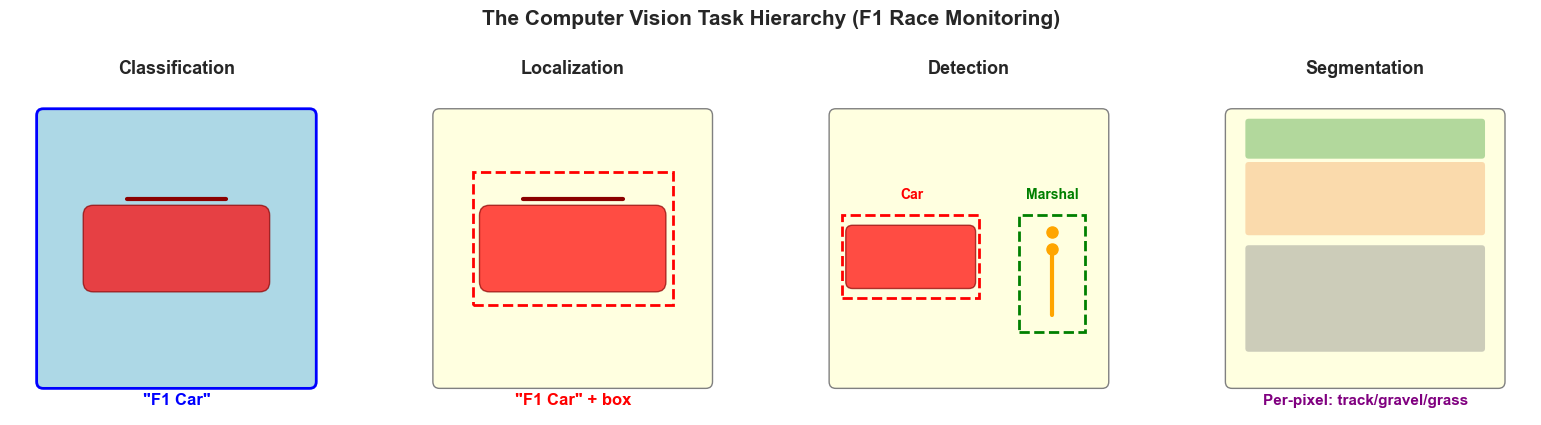

In [2]:
# Visualize the hierarchy of computer vision tasks in an F1 context
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax in axes:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')

# 1. Classification — "This frame contains an F1 car"
ax = axes[0]
ax.set_title('Classification', fontsize=13, fontweight='bold')
rect = patches.FancyBboxPatch((1, 1), 8, 8, boxstyle="round,pad=0.2",
                               facecolor='lightblue', edgecolor='blue', linewidth=2)
ax.add_patch(rect)
# Simplified car shape
car_body = patches.FancyBboxPatch((2.5, 4), 5, 2, boxstyle="round,pad=0.3",
                                   facecolor='red', edgecolor='darkred', alpha=0.7)
ax.add_patch(car_body)
ax.plot([3.5, 6.5], [6.5, 6.5], color='darkred', linewidth=3)  # rear wing
ax.text(5, 0.3, '"F1 Car"', ha='center', fontsize=12, fontweight='bold', color='blue')

# 2. Localization — car + bounding box
ax = axes[1]
ax.set_title('Localization', fontsize=13, fontweight='bold')
rect = patches.FancyBboxPatch((1, 1), 8, 8, boxstyle="round,pad=0.2",
                               facecolor='lightyellow', edgecolor='gray', linewidth=1)
ax.add_patch(rect)
car_body = patches.FancyBboxPatch((2.5, 4), 5, 2, boxstyle="round,pad=0.3",
                                   facecolor='red', edgecolor='darkred', alpha=0.7)
ax.add_patch(car_body)
ax.plot([3.5, 6.5], [6.5, 6.5], color='darkred', linewidth=3)
bbox = patches.Rectangle((2.0, 3.3), 6, 4.0, linewidth=2, edgecolor='red',
                          facecolor='none', linestyle='--')
ax.add_patch(bbox)
ax.text(5, 0.3, '"F1 Car" + box', ha='center', fontsize=12, fontweight='bold', color='red')

# 3. Detection — multiple objects (car + marshal + debris)
ax = axes[2]
ax.set_title('Detection', fontsize=13, fontweight='bold')
rect = patches.FancyBboxPatch((1, 1), 8, 8, boxstyle="round,pad=0.2",
                               facecolor='lightyellow', edgecolor='gray', linewidth=1)
ax.add_patch(rect)
car_body = patches.FancyBboxPatch((1.5, 4), 3.5, 1.5, boxstyle="round,pad=0.2",
                                   facecolor='red', edgecolor='darkred', alpha=0.7)
ax.add_patch(car_body)
# Marshal figure
ax.plot([7.5, 7.5], [3.0, 5.0], color='orange', linewidth=3)
ax.plot([7.5, 7.5], [5.0, 5.5], 'o', color='orange', markersize=8)
bbox1 = patches.Rectangle((1.2, 3.5), 4.1, 2.5, linewidth=2, edgecolor='red',
                           facecolor='none', linestyle='--')
ax.add_patch(bbox1)
bbox2 = patches.Rectangle((6.5, 2.5), 2, 3.5, linewidth=2, edgecolor='green',
                           facecolor='none', linestyle='--')
ax.add_patch(bbox2)
ax.text(3.3, 6.5, 'Car', fontsize=10, color='red', fontweight='bold', ha='center')
ax.text(7.5, 6.5, 'Marshal', fontsize=10, color='green', fontweight='bold', ha='center')

# 4. Segmentation — pixel-level track mapping
ax = axes[3]
ax.set_title('Segmentation', fontsize=13, fontweight='bold')
rect = patches.FancyBboxPatch((1, 1), 8, 8, boxstyle="round,pad=0.2",
                               facecolor='lightyellow', edgecolor='gray', linewidth=1)
ax.add_patch(rect)
# Track surface
track = patches.FancyBboxPatch((1.5, 2), 7, 3, boxstyle="round,pad=0.1",
                                facecolor='gray', edgecolor='none', alpha=0.4)
ax.add_patch(track)
# Gravel trap
gravel = patches.FancyBboxPatch((1.5, 5.5), 7, 2, boxstyle="round,pad=0.1",
                                 facecolor='sandybrown', edgecolor='none', alpha=0.4)
ax.add_patch(gravel)
# Grass
grass = patches.FancyBboxPatch((1.5, 7.8), 7, 1, boxstyle="round,pad=0.1",
                                facecolor='green', edgecolor='none', alpha=0.3)
ax.add_patch(grass)
ax.text(5, 0.3, 'Per-pixel: track/gravel/grass', ha='center', fontsize=11, fontweight='bold', color='purple')

plt.suptitle('The Computer Vision Task Hierarchy (F1 Race Monitoring)', fontsize=15, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

### Deep Dive: What CNNs Actually Learn

Recall from notebook 13 that CNN layers learn a hierarchy of increasingly abstract features:

| Layer Depth | What It Detects | Receptive Field | F1 Camera Analogy |
|------------|----------------|-----------------|-------------------|
| Layer 1 | Edges, gradients | 3x3 - 5x5 pixels | Individual tire marks on tarmac |
| Layer 2 | Textures, corners | 10-20 pixels | Curbing patterns, gravel texture |
| Layer 3 | Parts (wheels, wings) | 40-80 pixels | Front wing endplates, rear diffuser |
| Layer 4 | Objects (cars, marshals) | 100+ pixels | Complete F1 car, marshal with flag |
| Layer 5 | Scenes, contexts | Entire image | Full corner view — cars, barriers, run-off |

**Key insight:** For classification, we only care about the final layer's global summary. For detection and segmentation, we need the **spatial information** from intermediate layers — we need to know not just *what* features are present, but *where* they are. This is why detection and segmentation architectures carefully preserve and combine features from multiple depths.

> **F1 Insight:** When the FIA reviews track limit violations, they need layer-5 understanding ("a car is at this corner") combined with layer-2 precision ("the exact edge of the white line"). That is exactly the multi-scale challenge detection and segmentation architectures solve.

---

## 2. Object Detection Foundations

### Intuitive Explanation

Object detection answers: "What objects are in this image, and where is each one?" This requires predicting both a **class label** and a **bounding box** (x, y, width, height) for every object. The fundamental building blocks are:

1. **Anchor boxes** — a grid of pre-defined candidate regions tiled across the image (like standard car-sized templates at various angles and distances)
2. **IoU (Intersection over Union)** — the metric that measures how well a predicted box matches a ground truth box (how accurately your predicted car position matches the actual position)
3. **Non-Maximum Suppression (NMS)** — the post-processing step that removes duplicate detections (picking the best box when multiple overlapping boxes claim to detect the same car)

> **F1 Insight:** Imagine an overhead camera at Maggotts-Becketts at Silverstone. Multiple cars streak through the frame. The detection system needs to draw a tight bounding box around each one — even when cars are partially overlapping, at different distances from the camera, and moving at 280+ km/h. That is object detection in action.

Let's implement each one from scratch.

In [3]:
def compute_iou(box1, box2):
    """
    Compute Intersection over Union between two bounding boxes.
    
    In F1 terms: how well does your predicted car position overlap 
    with the actual car position? IoU=1.0 means perfect alignment.

    Args:
        box1: [x1, y1, x2, y2] -- top-left and bottom-right corners
        box2: [x1, y1, x2, y2] -- top-left and bottom-right corners

    Returns:
        IoU value between 0 and 1
    """
    # Compute intersection coordinates
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[2], box2[2])
    inter_y2 = min(box1[3], box2[3])

    # Compute intersection area (0 if no overlap)
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    inter_area = inter_width * inter_height

    # Compute union area
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area

    # Avoid division by zero
    if union_area == 0:
        return 0.0

    return inter_area / union_area

# Test IoU with F1 car detection examples
car_box_predicted = [1, 1, 4, 4]     # predicted car position
car_box_actual = [2, 2, 5, 5]        # actual car position (partial overlap)
car_box_missed = [5, 5, 8, 8]        # completely missed — no overlap
car_box_perfect = [1, 1, 4, 4]       # identical to prediction

print("IoU Examples (Car Detection Accuracy):")
print(f"  Partial overlap:  IoU(predicted, actual)  = {compute_iou(car_box_predicted, car_box_actual):.4f}")
print(f"  No overlap:       IoU(predicted, missed)  = {compute_iou(car_box_predicted, car_box_missed):.4f}")
print(f"  Perfect overlap:  IoU(predicted, perfect) = {compute_iou(car_box_predicted, car_box_perfect):.4f}")

# Verify: predicted and actual overlap in a 2x2 region. Union = 9+9-4 = 14. IoU = 4/14
print(f"\nManual check: 4/14 = {4/14:.4f}")

IoU Examples (Car Detection Accuracy):
  Partial overlap:  IoU(predicted, actual)  = 0.2857
  No overlap:       IoU(predicted, missed)  = 0.0000
  Perfect overlap:  IoU(predicted, perfect) = 1.0000

Manual check: 4/14 = 0.2857


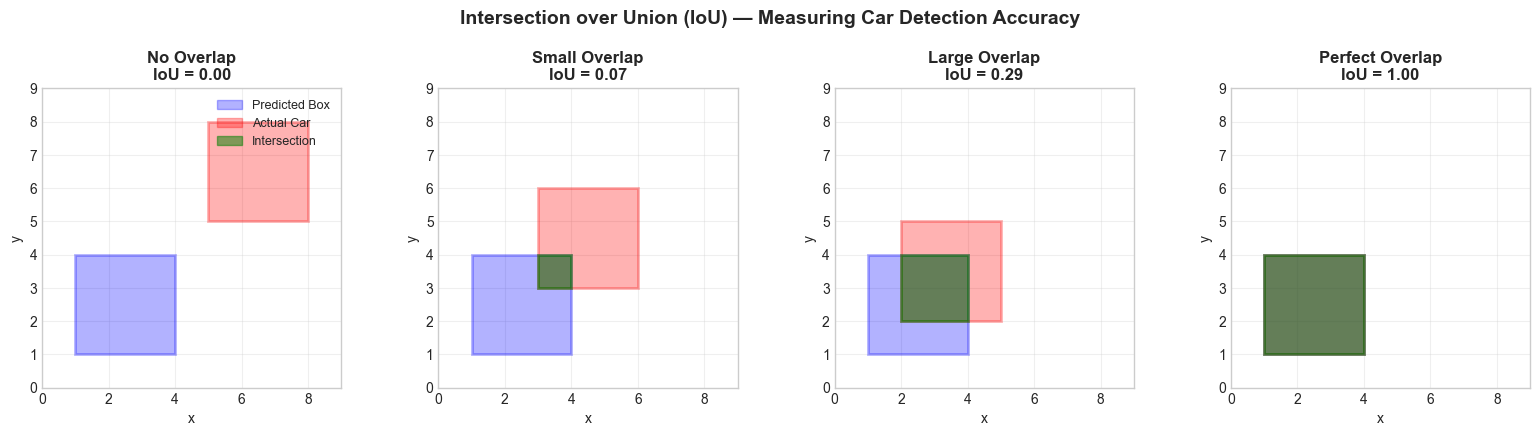

In [4]:
# Visualize IoU with different overlap levels — like car detection accuracy
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

examples = [
    ("No Overlap\nIoU = 0.00", [1, 1, 4, 4], [5, 5, 8, 8]),
    ("Small Overlap\nIoU = 0.07", [1, 1, 4, 4], [3, 3, 6, 6]),
    ("Large Overlap\nIoU = 0.29", [1, 1, 4, 4], [2, 2, 5, 5]),
    ("Perfect Overlap\nIoU = 1.00", [1, 1, 4, 4], [1, 1, 4, 4]),
]

for ax, (title, b1, b2) in zip(axes, examples):
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

    # Draw predicted box (blue)
    rect1 = patches.Rectangle((b1[0], b1[1]), b1[2]-b1[0], b1[3]-b1[1],
                                linewidth=2, edgecolor='blue', facecolor='blue', alpha=0.3)
    ax.add_patch(rect1)

    # Draw actual car position (red)
    rect2 = patches.Rectangle((b2[0], b2[1]), b2[2]-b2[0], b2[3]-b2[1],
                                linewidth=2, edgecolor='red', facecolor='red', alpha=0.3)
    ax.add_patch(rect2)

    # Highlight intersection (green)
    ix1, iy1 = max(b1[0], b2[0]), max(b1[1], b2[1])
    ix2, iy2 = min(b1[2], b2[2]), min(b1[3], b2[3])
    if ix2 > ix1 and iy2 > iy1:
        inter = patches.Rectangle((ix1, iy1), ix2-ix1, iy2-iy1,
                                   linewidth=2, edgecolor='green', facecolor='green', alpha=0.5)
        ax.add_patch(inter)

    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('x')
    ax.set_ylabel('y')

axes[0].legend([patches.Patch(color='blue', alpha=0.3),
                patches.Patch(color='red', alpha=0.3),
                patches.Patch(color='green', alpha=0.5)],
               ['Predicted Box', 'Actual Car', 'Intersection'], loc='upper right', fontsize=9)

plt.suptitle('Intersection over Union (IoU) — Measuring Car Detection Accuracy', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

### Anchor Boxes

Instead of searching every possible rectangle in an image, detection models tile the image with a set of **anchor boxes** (also called "priors" or "default boxes") at each spatial location. Each anchor has a predefined **aspect ratio** and **scale**. The network then predicts:

1. **Offsets** — small adjustments (dx, dy, dw, dh) to shift each anchor to better fit an object
2. **Objectness score** — probability that this anchor actually contains an object
3. **Class probabilities** — what kind of object it is

This is far more efficient than searching from scratch — the anchors provide a good starting point, and the network only needs to learn small refinements.

> **F1 Insight:** Think of anchor boxes as standard car-shaped templates at different angles and distances. An F1 car seen head-on from a trackside camera is a narrow vertical rectangle; the same car seen from an overhead helicopter camera is a long horizontal one; from far away it is a small dot. Anchors pre-define these common shapes so the network just needs to nudge each template rather than discover car shapes from scratch.

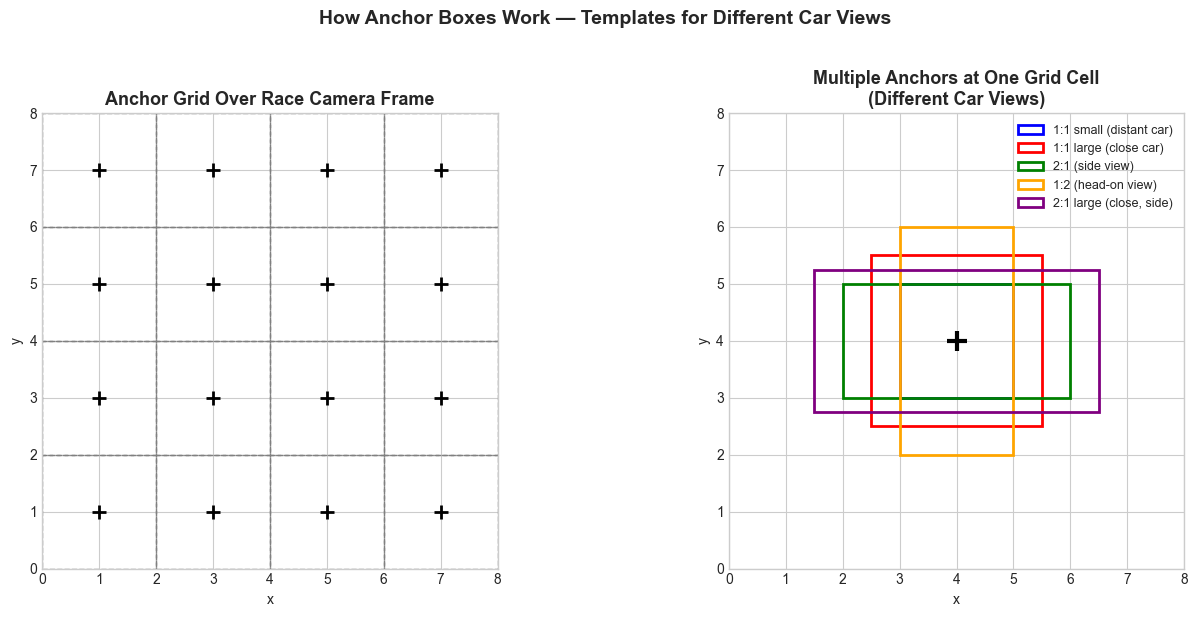

At each grid cell, multiple anchors with different shapes cover various car orientations.
With a 4x4 grid and 5 anchors per cell: 80 total anchors.


In [5]:
# Visualize anchor boxes tiled across an overhead track camera view
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: grid of anchor centers across the camera frame
ax = axes[0]
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.set_title('Anchor Grid Over Race Camera Frame', fontsize=13, fontweight='bold')

# Create a grid of anchor centers
grid_size = 4
for i in range(grid_size):
    for j in range(grid_size):
        cx = i * 2 + 1
        cy = j * 2 + 1
        ax.plot(cx, cy, 'k+', markersize=10, markeredgewidth=2)
        rect = patches.Rectangle((i*2, j*2), 2, 2, linewidth=1,
                                  edgecolor='gray', facecolor='none', linestyle='--')
        ax.add_patch(rect)

ax.set_xlabel('x')
ax.set_ylabel('y')

# Right: multiple anchors at one location — different car orientations/distances
ax = axes[1]
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.set_title('Multiple Anchors at One Grid Cell\n(Different Car Views)', fontsize=13, fontweight='bold')

cx, cy = 4, 4
ax.plot(cx, cy, 'k+', markersize=15, markeredgewidth=3)

# Different aspect ratios matching car orientations/distances
anchors = [
    (2, 2, 'blue', '1:1 small (distant car)'),
    (3, 3, 'red', '1:1 large (close car)'),
    (4, 2, 'green', '2:1 (side view)'),
    (2, 4, 'orange', '1:2 (head-on view)'),
    (5, 2.5, 'purple', '2:1 large (close, side)'),
]

for w, h, color, label in anchors:
    rect = patches.Rectangle((cx - w/2, cy - h/2), w, h,
                              linewidth=2, edgecolor=color, facecolor='none',
                              linestyle='-', label=label)
    ax.add_patch(rect)

ax.legend(loc='upper right', fontsize=9)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.suptitle('How Anchor Boxes Work — Templates for Different Car Views', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("At each grid cell, multiple anchors with different shapes cover various car orientations.")
print(f"With a {grid_size}x{grid_size} grid and {len(anchors)} anchors per cell: {grid_size**2 * len(anchors)} total anchors.")

### Non-Maximum Suppression (NMS)

A detection model with many anchors will typically produce **multiple overlapping detections** for the same object. NMS cleans this up:

1. Sort all detections by confidence score (highest first)
2. Take the highest-scoring detection as a "keep"
3. Remove all other detections that overlap with it above an IoU threshold (e.g., 0.5)
4. Repeat with the next highest-scoring surviving detection
5. Continue until no detections remain

**What this means:** NMS keeps the single best detection for each object and suppresses the duplicates.

> **F1 Insight:** Picture a trackside camera at the Monaco hairpin. The model fires off five overlapping bounding boxes on Leclerc's car, each with a slightly different confidence score. NMS selects the single tightest, most confident box and discards the rest. Without NMS, your race monitoring dashboard would show five ghost cars where there is only one.

In [6]:
def nms(boxes, scores, iou_threshold=0.5):
    """
    Non-Maximum Suppression: remove duplicate detections.
    
    Like picking the single best bounding box for each car when
    multiple overlapping boxes all claim to detect it.

    Args:
        boxes: list of [x1, y1, x2, y2] bounding boxes
        scores: list of confidence scores (one per box)
        iou_threshold: IoU above which a box is considered duplicate

    Returns:
        List of indices of boxes to keep
    """
    if len(boxes) == 0:
        return []

    # Sort by score (descending)
    order = np.argsort(scores)[::-1]

    keep = []
    while len(order) > 0:
        # Keep the highest scoring box
        best_idx = order[0]
        keep.append(best_idx)

        # Compare with all remaining boxes
        remaining = order[1:]
        suppress = []

        for i, idx in enumerate(remaining):
            iou = compute_iou(boxes[best_idx], boxes[idx])
            if iou >= iou_threshold:
                suppress.append(i)

        # Remove suppressed boxes
        order = np.delete(remaining, suppress)

    return keep

# Test NMS: multiple detections of the same car + a separate car
car_detections = [
    [1, 1, 4, 4],         # detection on Car A
    [1.2, 1.1, 4.2, 4.1], # overlapping detection on Car A
    [1.5, 1.3, 4.5, 4.3], # another overlapping detection on Car A
    [6, 6, 9, 9],         # detection on Car B (separate)
]
detection_scores = [0.9, 0.75, 0.8, 0.85]

kept = nms(car_detections, detection_scores, iou_threshold=0.5)
print("NMS Results (Removing Duplicate Car Detections):")
print(f"  Input: {len(car_detections)} detections")
print(f"  Kept indices: {kept}")
print(f"  Kept scores: {[detection_scores[i] for i in kept]}")
print(f"  Output: {len(kept)} detections (one per actual car)")

NMS Results (Removing Duplicate Car Detections):
  Input: 4 detections
  Kept indices: [np.int64(0), np.int64(3)]
  Kept scores: [0.9, 0.85]
  Output: 2 detections (one per actual car)


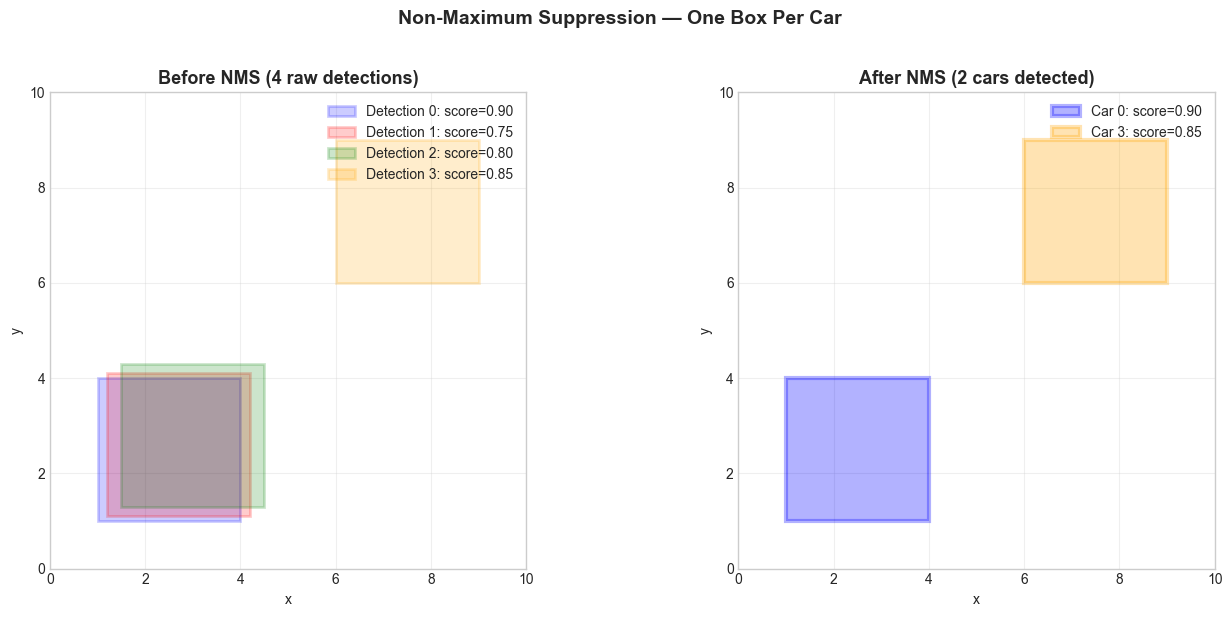

In [7]:
# Visualize NMS before and after — filtering duplicate car detections
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

colors = ['blue', 'red', 'green', 'orange']

# Before NMS — multiple overlapping boxes on the same car
ax = axes[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.set_title(f'Before NMS ({len(car_detections)} raw detections)', fontsize=13, fontweight='bold')

for i, (box, score, color) in enumerate(zip(car_detections, detection_scores, colors)):
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                              linewidth=2, edgecolor=color, facecolor=color, alpha=0.2,
                              label=f'Detection {i}: score={score:.2f}')
    ax.add_patch(rect)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True, alpha=0.3)

# After NMS — one clean box per car
ax = axes[1]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.set_aspect('equal')
ax.set_title(f'After NMS ({len(kept)} cars detected)', fontsize=13, fontweight='bold')

for i in kept:
    box = car_detections[i]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                              linewidth=3, edgecolor=colors[i], facecolor=colors[i], alpha=0.3,
                              label=f'Car {i}: score={detection_scores[i]:.2f}')
    ax.add_patch(rect)

ax.legend(loc='upper right', fontsize=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(True, alpha=0.3)

plt.suptitle('Non-Maximum Suppression — One Box Per Car', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## 3. YOLO: You Only Look Once

### Intuitive Explanation

Early detection methods like R-CNN were **two-stage**: first propose candidate regions, then classify each one. This was accurate but slow — hundreds of separate classification passes per image.

**YOLO** revolutionized detection by framing it as a **single regression problem**: one neural network pass predicts all bounding boxes and class probabilities simultaneously.

> **F1 Insight:** During a live Grand Prix, race control cameras need to process frames at 30+ fps. A two-stage detector that takes 2 seconds per frame would miss entire overtakes. YOLO's single-pass architecture is what makes real-time race monitoring possible — detecting 20 cars, multiple marshals, flags, and debris all in one shot, fast enough to keep up with 300+ km/h action.

#### How YOLO Works

1. **Divide** the image into an S x S grid (e.g., 7x7)
2. Each grid cell predicts **B bounding boxes**, each with:
   - 4 coordinates: (x, y, w, h) relative to the cell
   - 1 objectness confidence: P(object) x IoU(pred, truth)
3. Each grid cell also predicts **C class probabilities** (shared across all B boxes)
4. The output tensor has shape: **S x S x (B x 5 + C)**

For example, with S=7, B=2, and C=20 (PASCAL VOC classes):
- Output shape: 7 x 7 x (2 x 5 + 20) = 7 x 7 x 30

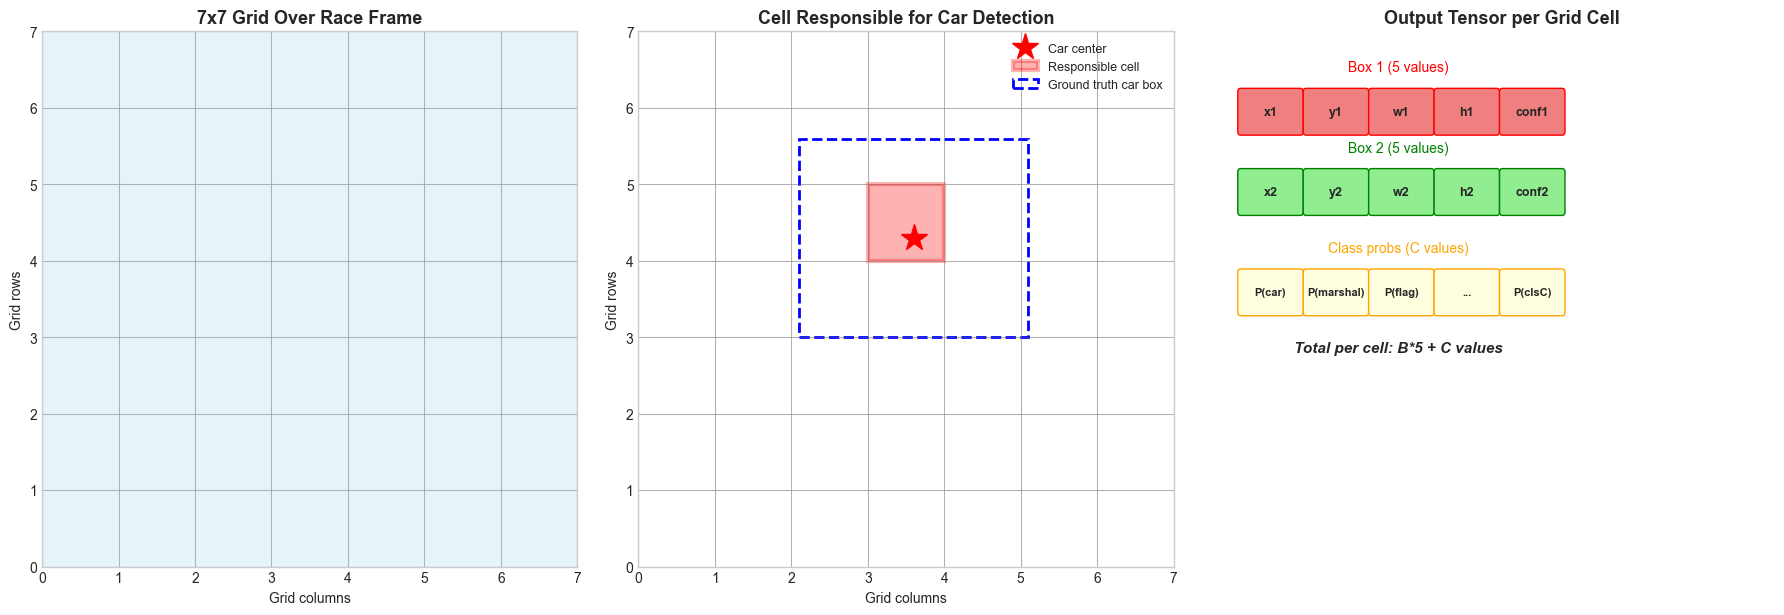

In [8]:
# Visualize YOLO grid-based detection on a race camera frame
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

S = 7  # grid size

# 1. The grid overlaid on a race frame
ax = axes[0]
ax.set_xlim(0, S)
ax.set_ylim(0, S)
ax.set_aspect('equal')
ax.set_title(f'{S}x{S} Grid Over Race Frame', fontsize=13, fontweight='bold')

for i in range(S + 1):
    ax.axhline(y=i, color='gray', linewidth=0.5, alpha=0.5)
    ax.axvline(x=i, color='gray', linewidth=0.5, alpha=0.5)

ax.fill_between([0, S], 0, S, color='lightblue', alpha=0.3)
ax.set_xlabel('Grid columns')
ax.set_ylabel('Grid rows')

# 2. Cell responsible for a detected car
ax = axes[1]
ax.set_xlim(0, S)
ax.set_ylim(0, S)
ax.set_aspect('equal')
ax.set_title('Cell Responsible for Car Detection', fontsize=13, fontweight='bold')

for i in range(S + 1):
    ax.axhline(y=i, color='gray', linewidth=0.5, alpha=0.5)
    ax.axvline(x=i, color='gray', linewidth=0.5, alpha=0.5)

car_cx, car_cy = 3.6, 4.3
ax.plot(car_cx, car_cy, 'r*', markersize=20, label='Car center')
responsible_cell = patches.Rectangle((3, 4), 1, 1, linewidth=3,
                                      edgecolor='red', facecolor='red', alpha=0.3,
                                      label='Responsible cell')
ax.add_patch(responsible_cell)

car_box = patches.Rectangle((2.1, 3.0), 3.0, 2.6, linewidth=2,
                             edgecolor='blue', facecolor='none', linestyle='--',
                             label='Ground truth car box')
ax.add_patch(car_box)
ax.legend(loc='upper right', fontsize=9)
ax.set_xlabel('Grid columns')
ax.set_ylabel('Grid rows')

# 3. Output tensor structure
ax = axes[2]
ax.set_xlim(0, 10)
ax.set_ylim(0, 8)
ax.axis('off')
ax.set_title('Output Tensor per Grid Cell', fontsize=13, fontweight='bold')

y_start = 6.5
box_h = 0.6
box_w = 1.2

elements_b1 = ['x1', 'y1', 'w1', 'h1', 'conf1']
for i, elem in enumerate(elements_b1):
    rect = patches.FancyBboxPatch((i * box_w + 0.2, y_start), box_w - 0.1, box_h,
                                   boxstyle="round,pad=0.05", facecolor='lightcoral', edgecolor='red')
    ax.add_patch(rect)
    ax.text(i * box_w + 0.2 + (box_w-0.1)/2, y_start + box_h/2, elem,
            ha='center', va='center', fontsize=9, fontweight='bold')
ax.text(3.1, y_start + box_h + 0.3, 'Box 1 (5 values)', ha='center', fontsize=10, color='red')

y_b2 = y_start - 1.2
for i, elem in enumerate(elements_b1):
    elem2 = elem.replace('1', '2')
    rect = patches.FancyBboxPatch((i * box_w + 0.2, y_b2), box_w - 0.1, box_h,
                                   boxstyle="round,pad=0.05", facecolor='lightgreen', edgecolor='green')
    ax.add_patch(rect)
    ax.text(i * box_w + 0.2 + (box_w-0.1)/2, y_b2 + box_h/2, elem2,
            ha='center', va='center', fontsize=9, fontweight='bold')
ax.text(3.1, y_b2 + box_h + 0.3, 'Box 2 (5 values)', ha='center', fontsize=10, color='green')

y_cls = y_b2 - 1.5
cls_labels = ['P(car)', 'P(marshal)', 'P(flag)', '...', 'P(clsC)']
for i, elem in enumerate(cls_labels):
    rect = patches.FancyBboxPatch((i * box_w + 0.2, y_cls), box_w - 0.1, box_h,
                                   boxstyle="round,pad=0.05", facecolor='lightyellow', edgecolor='orange')
    ax.add_patch(rect)
    ax.text(i * box_w + 0.2 + (box_w-0.1)/2, y_cls + box_h/2, elem,
            ha='center', va='center', fontsize=8, fontweight='bold')
ax.text(3.1, y_cls + box_h + 0.3, 'Class probs (C values)', ha='center', fontsize=10, color='orange')

ax.text(3.1, y_cls - 0.6, 'Total per cell: B*5 + C values', ha='center', fontsize=11,
        fontweight='bold', style='italic')

plt.tight_layout()
plt.show()

In [9]:
class SimpleYOLOHead(nn.Module):
    """
    Simplified YOLO-style detection head for race monitoring.
    Takes a feature map and predicts bounding boxes + classes per grid cell.
    
    In an F1 context, this head would predict car positions, marshal locations,
    flag types, and debris from each grid cell of the race camera frame.
    """
    def __init__(self, in_channels, S=7, B=2, C=20):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
            nn.Conv2d(256, B * 5 + C, 1),
        )

    def forward(self, x):
        """
        Args:
            x: feature map of shape (batch, in_channels, S, S)
        Returns:
            predictions: (batch, S, S, B*5 + C)
        """
        out = self.conv(x)
        out = out.permute(0, 2, 3, 1)
        return out

    def decode(self, predictions):
        """Decode raw predictions into boxes, confidences, and class probs."""
        batch_size = predictions.shape[0]

        box_preds = predictions[..., :self.B * 5].reshape(
            batch_size, self.S, self.S, self.B, 5
        )
        class_preds = predictions[..., self.B * 5:]

        # xy: car center position within grid cell
        xy = torch.sigmoid(box_preds[..., :2])
        # wh: car bounding box width and height
        wh = box_preds[..., 2:4]
        # conf: confidence that this cell contains a car/object
        conf = torch.sigmoid(box_preds[..., 4])
        # class_probs: what type of object (car, marshal, flag, debris, etc.)
        class_probs = torch.softmax(class_preds, dim=-1)

        return xy, wh, conf, class_probs

# Demo: simulate YOLO detection head for race monitoring
S, B, C = 7, 2, 20
race_detection_head = SimpleYOLOHead(in_channels=512, S=S, B=B, C=C)

dummy_race_features = torch.randn(1, 512, S, S)
race_predictions = race_detection_head(dummy_race_features)

print(f"Input feature map:  {dummy_race_features.shape}")
print(f"Output predictions: {race_predictions.shape}")
print(f"  Per cell: {B*5 + C} values = {B} boxes x 5 + {C} classes")

xy, wh, conf, class_probs = race_detection_head.decode(race_predictions)
print(f"\nDecoded (for each grid cell over the race frame):")
print(f"  Car centers (xy):        {xy.shape}")
print(f"  Car box sizes (wh):      {wh.shape}")
print(f"  Detection confidence:    {conf.shape}")
print(f"  Class probabilities:     {class_probs.shape}")

Input feature map:  torch.Size([1, 512, 7, 7])
Output predictions: torch.Size([1, 7, 7, 30])
  Per cell: 30 values = 2 boxes x 5 + 20 classes

Decoded (for each grid cell over the race frame):
  Car centers (xy):        torch.Size([1, 7, 7, 2, 2])
  Car box sizes (wh):      torch.Size([1, 7, 7, 2, 2])
  Detection confidence:    torch.Size([1, 7, 7, 2])
  Class probabilities:     torch.Size([1, 7, 7, 20])


### Deep Dive: One-Stage vs Two-Stage Detectors

| Aspect | Two-Stage (R-CNN family) | One-Stage (YOLO, SSD) | F1 Parallel |
|--------|------------------------|----------------------|-------------|
| **Pipeline** | Region proposal, then classify each region | Single pass: grid predictions for all boxes | Reviewing each corner individually vs scanning the whole track at once |
| **Speed** | Slower (separate steps) | Faster (single forward pass) | Post-race analysis vs live race monitoring |
| **Accuracy** | Generally higher for small objects | Competitive, sometimes lower on small objects | Better at spotting small debris; competitive on cars |
| **Examples** | R-CNN, Fast R-CNN, Faster R-CNN | YOLO, SSD, RetinaNet | — |
| **Key innovation** | Region Proposal Network (RPN) | Grid-based direct prediction | — |
| **Use case** | When accuracy matters most | When speed matters (real-time) | Incident review vs live broadcast overlay |

#### Key Insight

The fundamental tradeoff is **thoroughness vs speed**. Two-stage detectors carefully examine each proposed region, while one-stage detectors make predictions everywhere simultaneously. Modern one-stage detectors like YOLOv8 have largely closed the accuracy gap, making them the dominant choice for most real-world applications.

> **F1 Insight:** F1 broadcast graphics that overlay car positions in real-time use one-stage detection — speed is paramount. But when the FIA reviews an incident after the race (did that front wing endplate fly into the path of another car?), a slower, more thorough two-stage detector may be preferred for maximum accuracy.

#### Common Misconceptions

| Misconception | Reality |
|---------------|--------|
| "YOLO is always less accurate" | Modern YOLO versions rival two-stage detectors on most benchmarks |
| "Two-stage is always better for small objects" | Techniques like Feature Pyramid Networks (FPN) help one-stage detectors with small objects |
| "You must choose one approach" | Many systems combine ideas from both families |

---

## 4. Semantic Segmentation

### Intuitive Explanation

Semantic segmentation assigns a **class label to every single pixel** in the image. Unlike detection (which draws boxes), segmentation produces a precise mask showing exactly which pixels belong to each category.

The core challenge: CNNs for classification progressively **downsample** the spatial resolution (via pooling and striding) to build high-level features. But segmentation needs **pixel-level output** — the same resolution as the input. How do we get back to full resolution?

The answer: **encoder-decoder architectures** that first compress (encode) then expand (decode) the spatial dimensions.

> **F1 Insight:** Track limit enforcement is the ultimate segmentation problem. The FIA needs to know, for every single pixel in the camera frame, whether it is **track surface** (gray tarmac), **curbing** (red-and-white stripes), **gravel trap** (sand), **grass** (green), or **barrier** (metal/tire wall). A bounding box around the track is useless — you need pixel-perfect boundaries to determine if a tire crossed the white line by even a centimeter at the exit of Turn 4.

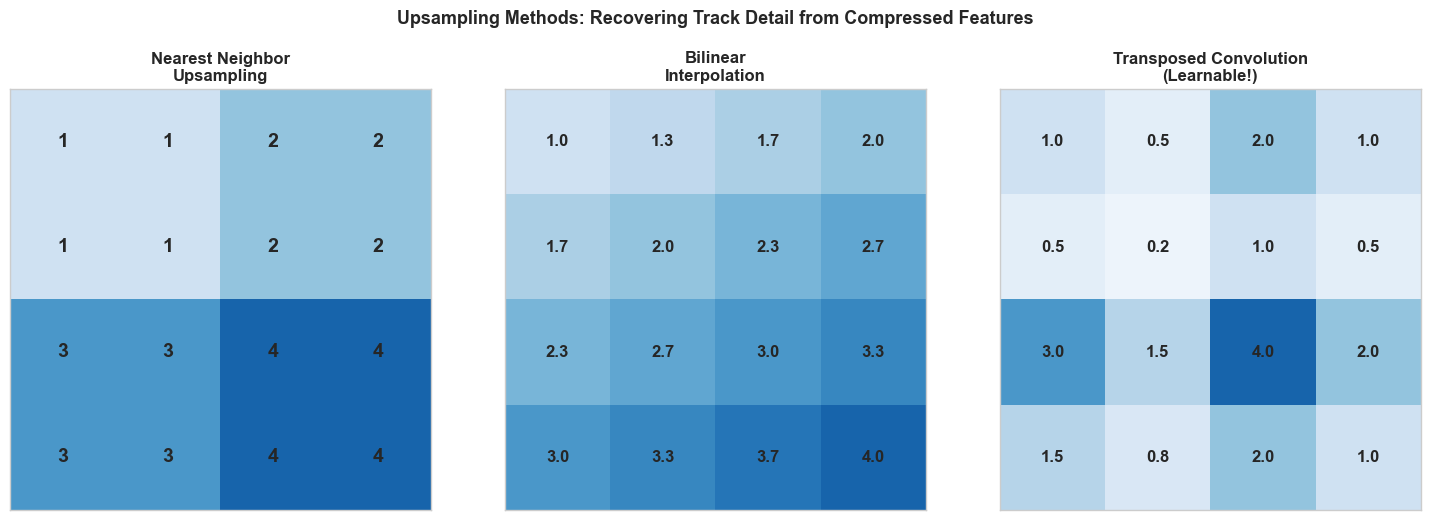

Key difference: Transposed convolution has LEARNABLE parameters.
The network can learn the best way to upsample for track boundary recovery.


In [10]:
# Demonstrate upsampling methods — how we recover spatial resolution for track segmentation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create a small "feature map" (think: compressed track image)
small = np.array([[1, 2],
                   [3, 4]], dtype=float)

# Method 1: Nearest neighbor upsampling
ax = axes[0]
nearest = np.repeat(np.repeat(small, 2, axis=0), 2, axis=1)
im = ax.imshow(nearest, cmap='Blues', vmin=0, vmax=5)
ax.set_title('Nearest Neighbor\nUpsampling', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        ax.text(j, i, f'{nearest[i,j]:.0f}', ha='center', va='center', fontsize=14, fontweight='bold')
ax.set_xticks([]); ax.set_yticks([])

# Method 2: Bilinear interpolation
ax = axes[1]
small_tensor = torch.tensor(small).unsqueeze(0).unsqueeze(0).float()
bilinear = F.interpolate(small_tensor, scale_factor=2, mode='bilinear', align_corners=True)
bilinear_np = bilinear.squeeze().numpy()
im = ax.imshow(bilinear_np, cmap='Blues', vmin=0, vmax=5)
ax.set_title('Bilinear\nInterpolation', fontsize=12, fontweight='bold')
for i in range(4):
    for j in range(4):
        ax.text(j, i, f'{bilinear_np[i,j]:.1f}', ha='center', va='center', fontsize=12, fontweight='bold')
ax.set_xticks([]); ax.set_yticks([])

# Method 3: Transposed convolution (learnable!)
ax = axes[2]
conv_t = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
conv_t.weight.data = torch.tensor([[[[1.0, 0.5], [0.5, 0.25]]]])
with torch.no_grad():
    trans_out = conv_t(small_tensor)
trans_np = trans_out.squeeze().numpy()
im = ax.imshow(trans_np, cmap='Blues', vmin=0, vmax=5)
ax.set_title('Transposed Convolution\n(Learnable!)', fontsize=12, fontweight='bold')
for i in range(trans_np.shape[0]):
    for j in range(trans_np.shape[1]):
        ax.text(j, i, f'{trans_np[i,j]:.1f}', ha='center', va='center', fontsize=12, fontweight='bold')
ax.set_xticks([]); ax.set_yticks([])

plt.suptitle('Upsampling Methods: Recovering Track Detail from Compressed Features',
             fontsize=13, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print("Key difference: Transposed convolution has LEARNABLE parameters.")
print("The network can learn the best way to upsample for track boundary recovery.")

### The U-Net Architecture

U-Net is the most influential segmentation architecture, originally designed for biomedical image segmentation. Its key innovation is **skip connections** between the encoder and decoder at matching resolutions:

```
Encoder (Downsampling)          Decoder (Upsampling)

Input (256x256)  ------------------>  Output (256x256)
    | conv+pool                          ^ upconv+concat
    v                                    |
  (128x128)  ------------------------> (128x128)
    | conv+pool                          ^ upconv+concat
    v                                    |
   (64x64)  ------------------------->  (64x64)
    | conv+pool                          ^ upconv+concat
    v                                    |
   (32x32)  ------------------------->  (32x32)
    | conv+pool                          ^ upconv
    v                                    |
          (16x16) Bottleneck
```

#### Why Skip Connections?

The encoder captures **what** features are present (semantics) but loses **where** they are (spatial detail). The decoder needs to recover precise boundaries. Skip connections pass the high-resolution spatial information directly from the encoder to the decoder, giving it both:

- **Deep features** (from the bottleneck path): "This region is track surface"
- **Fine details** (from the skip connections): "The exact boundary between tarmac and gravel"

This combination produces sharp, accurate segmentation masks.

> **F1 Insight:** Think of the encoder as the helicopter view that tells you "there is a corner complex here with run-off areas," while the skip connections carry the ground-level camera detail that shows "the white line separating track from curbing runs exactly here." You need both to enforce track limits at pixel precision.

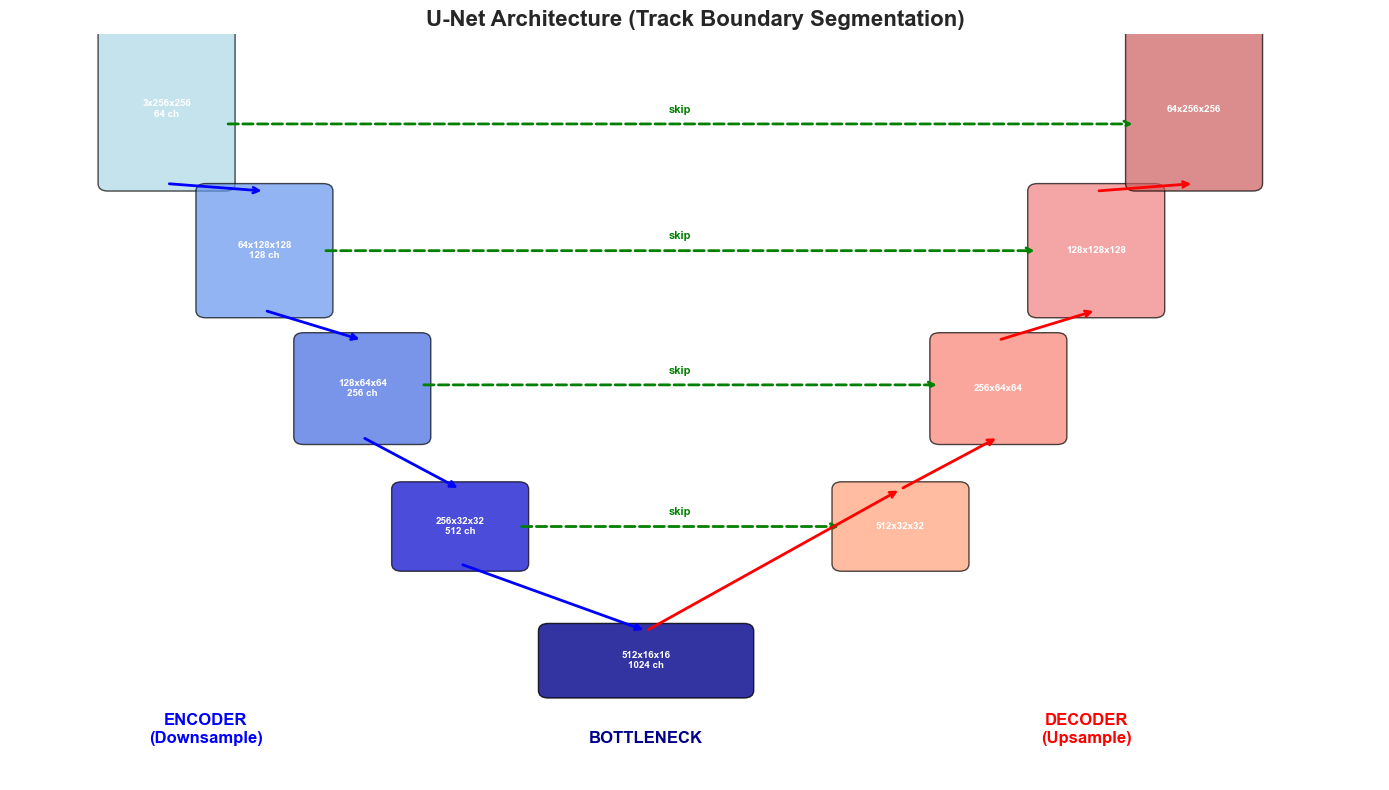

In [11]:
# Visualize U-Net architecture for track segmentation
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_xlim(0, 14)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('U-Net Architecture (Track Boundary Segmentation)', fontsize=16, fontweight='bold')

# Encoder blocks (left side, going down)
encoder_blocks = [
    (1, 8, 2.0, 1.2, '3x256x256\n64 ch', 'lightblue'),
    (2, 6.3, 1.6, 1.2, '64x128x128\n128 ch', 'cornflowerblue'),
    (3, 4.6, 1.3, 1.2, '128x64x64\n256 ch', 'royalblue'),
    (4, 2.9, 1.0, 1.2, '256x32x32\n512 ch', 'mediumblue'),
]

# Bottleneck
bottleneck = (5.5, 1.2, 0.8, 2.0, '512x16x16\n1024 ch', 'darkblue')

# Decoder blocks (right side, going up)
decoder_blocks = [
    (8.5, 2.9, 1.0, 1.2, '512x32x32', 'lightsalmon'),
    (9.5, 4.6, 1.3, 1.2, '256x64x64', 'salmon'),
    (10.5, 6.3, 1.6, 1.2, '128x128x128', 'lightcoral'),
    (11.5, 8, 2.0, 1.2, '64x256x256', 'indianred'),
]

# Draw encoder
for x, y, w, h, label, color in encoder_blocks:
    rect = patches.FancyBboxPatch((x, y), h, w, boxstyle="round,pad=0.1",
                                   facecolor=color, edgecolor='black', alpha=0.7)
    ax.add_patch(rect)
    ax.text(x + h/2, y + w/2, label, ha='center', va='center', fontsize=7, color='white', fontweight='bold')

# Draw bottleneck
bx, by, bw, bh, blabel, bcolor = bottleneck
rect = patches.FancyBboxPatch((bx, by), bh, bw, boxstyle="round,pad=0.1",
                               facecolor=bcolor, edgecolor='black', alpha=0.8)
ax.add_patch(rect)
ax.text(bx + bh/2, by + bw/2, blabel, ha='center', va='center', fontsize=7, color='white', fontweight='bold')

# Draw decoder
for x, y, w, h, label, color in decoder_blocks:
    rect = patches.FancyBboxPatch((x, y), h, w, boxstyle="round,pad=0.1",
                                   facecolor=color, edgecolor='black', alpha=0.7)
    ax.add_patch(rect)
    ax.text(x + h/2, y + w/2, label, ha='center', va='center', fontsize=7, color='white', fontweight='bold')

# Draw skip connections (horizontal arrows)
skip_ys = [8.8, 7.1, 5.3, 3.4]
enc_rights = [2.2, 3.2, 4.2, 5.2]
dec_lefts = [11.5, 10.5, 9.5, 8.5]
for sy, er, dl in zip(skip_ys, enc_rights, dec_lefts):
    ax.annotate('', xy=(dl, sy), xytext=(er, sy),
                arrowprops=dict(arrowstyle='->', color='green', lw=2, linestyle='--'))
    ax.text((er + dl) / 2, sy + 0.15, 'skip', ha='center', fontsize=8, color='green', fontweight='bold')

# Down arrows (encoder)
for i in range(3):
    x_from = encoder_blocks[i][0] + encoder_blocks[i][3]/2
    y_from = encoder_blocks[i][1]
    x_to = encoder_blocks[i+1][0] + encoder_blocks[i+1][3]/2
    y_to = encoder_blocks[i+1][1] + encoder_blocks[i+1][2]
    ax.annotate('', xy=(x_to, y_to), xytext=(x_from, y_from),
                arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# Arrow from last encoder to bottleneck
ax.annotate('', xy=(bx + bh/2, by + bw),
            xytext=(encoder_blocks[-1][0] + encoder_blocks[-1][3]/2, encoder_blocks[-1][1]),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))

# Arrow from bottleneck to first decoder
ax.annotate('', xy=(decoder_blocks[0][0] + decoder_blocks[0][3]/2, decoder_blocks[0][1] + decoder_blocks[0][2]),
            xytext=(bx + bh/2, by + bw),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Up arrows (decoder)
for i in range(3):
    x_from = decoder_blocks[i][0] + decoder_blocks[i][3]/2
    y_from = decoder_blocks[i][1] + decoder_blocks[i][2]
    x_to = decoder_blocks[i+1][0] + decoder_blocks[i+1][3]/2
    y_to = decoder_blocks[i+1][1]
    ax.annotate('', xy=(x_to, y_to), xytext=(x_from, y_from),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))

# Labels
ax.text(2, 0.5, 'ENCODER\n(Downsample)', ha='center', fontsize=12, fontweight='bold', color='blue')
ax.text(6.5, 0.5, 'BOTTLENECK', ha='center', fontsize=12, fontweight='bold', color='darkblue')
ax.text(11, 0.5, 'DECODER\n(Upsample)', ha='center', fontsize=12, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

In [12]:
class DoubleConv(nn.Module):
    """Two consecutive conv-batchnorm-relu blocks (the basic U-Net building block)."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)


class MiniUNet(nn.Module):
    """
    A compact U-Net for semantic segmentation.
    
    Applied to F1: this architecture could segment a race camera frame into
    track surface, curbing, gravel, grass, barrier, car, marshal, etc.

    Architecture:
        Encoder: 3 downsampling stages (channels: 64 -> 128 -> 256)
        Bottleneck: 512 channels
        Decoder: 3 upsampling stages with skip connections
        Output: num_classes channels (one per surface/object class)
    """
    def __init__(self, in_channels=3, num_classes=10):
        super().__init__()

        # Encoder path — compress spatial detail, build semantic understanding
        self.enc1 = DoubleConv(in_channels, 64)
        self.enc2 = DoubleConv(64, 128)
        self.enc3 = DoubleConv(128, 256)
        self.pool = nn.MaxPool2d(2, 2)

        # Bottleneck — deepest semantic representation
        self.bottleneck = DoubleConv(256, 512)

        # Decoder path — recover spatial detail with skip connections
        # (note: input channels = skip + upsampled)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(512, 256)  # 256 (up) + 256 (skip) = 512 in

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(256, 128)  # 128 (up) + 128 (skip) = 256 in

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(128, 64)   # 64 (up) + 64 (skip) = 128 in

        # Final 1x1 convolution to get per-pixel class predictions
        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder — "what is in the frame?"
        e1 = self.enc1(x)             # (B, 64, H, W)
        e2 = self.enc2(self.pool(e1)) # (B, 128, H/2, W/2)
        e3 = self.enc3(self.pool(e2)) # (B, 256, H/4, W/4)

        # Bottleneck — deepest understanding
        b = self.bottleneck(self.pool(e3))  # (B, 512, H/8, W/8)

        # Decoder with skip connections — "where exactly are the boundaries?"
        d3 = self.up3(b)                    # (B, 256, H/4, W/4)
        d3 = torch.cat([d3, e3], dim=1)     # (B, 512, H/4, W/4)
        d3 = self.dec3(d3)                  # (B, 256, H/4, W/4)

        d2 = self.up2(d3)                   # (B, 128, H/2, W/2)
        d2 = torch.cat([d2, e2], dim=1)     # (B, 256, H/2, W/2)
        d2 = self.dec2(d2)                  # (B, 128, H/2, W/2)

        d1 = self.up1(d2)                   # (B, 64, H, W)
        d1 = torch.cat([d1, e1], dim=1)     # (B, 128, H, W)
        d1 = self.dec1(d1)                  # (B, 64, H, W)

        return self.final(d1)               # (B, num_classes, H, W)

# Test the Mini U-Net for track segmentation
# 10 classes: track, curbing, gravel, grass, barrier, car, marshal, flag, debris, sky
track_segmenter = MiniUNet(in_channels=3, num_classes=10)

race_frame = torch.randn(2, 3, 64, 64)
track_map = track_segmenter(race_frame)

print(f"Input shape:  {race_frame.shape}  -> (batch, RGB channels, height, width)")
print(f"Output shape: {track_map.shape} -> (batch, num_classes, height, width)")
print(f"\nOutput is a per-pixel surface/object classification!")
print(f"To get the segmentation map: output.argmax(dim=1) -> shape {track_map.argmax(dim=1).shape}")

total_params = sum(p.numel() for p in track_segmenter.parameters())
print(f"\nTotal parameters: {total_params:,}")

Input shape:  torch.Size([2, 3, 64, 64])  -> (batch, RGB channels, height, width)
Output shape: torch.Size([2, 10, 64, 64]) -> (batch, num_classes, height, width)

Output is a per-pixel surface/object classification!
To get the segmentation map: output.argmax(dim=1) -> shape torch.Size([2, 64, 64])

Total parameters: 7,703,562


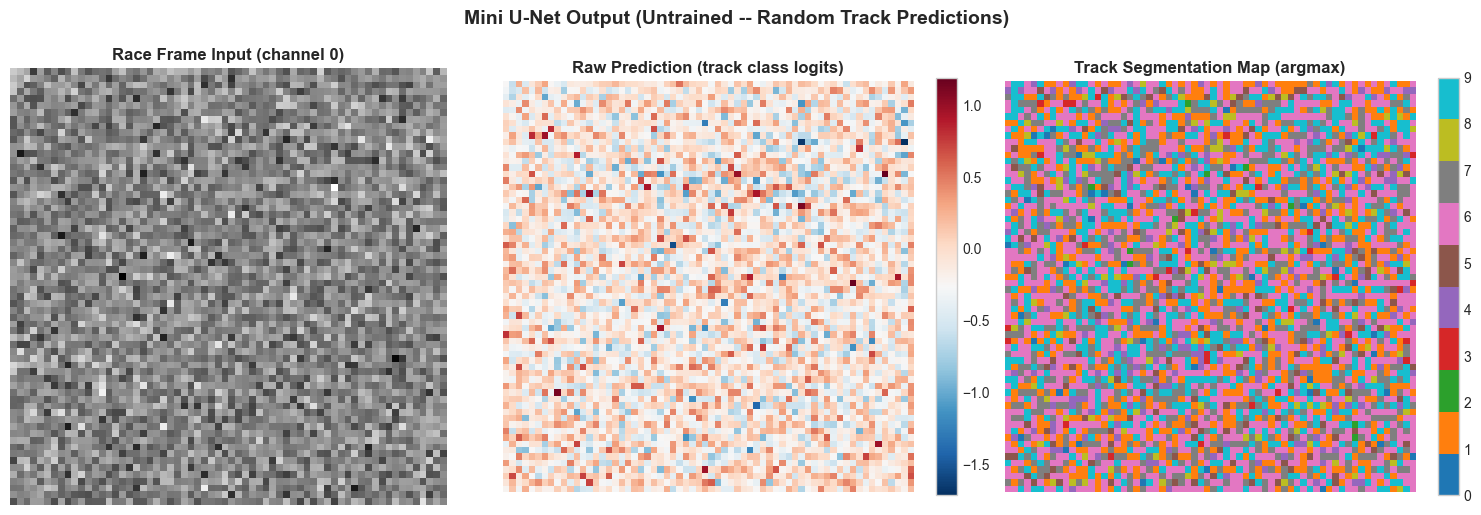

Note: The model is untrained, so predictions are random.
After training on labeled track data, each pixel would correctly show:
  track surface, curbing, gravel, grass, barrier, car, marshal, etc.


In [13]:
# Visualize what the U-Net produces on a race camera frame
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

np.random.seed(42)
torch.manual_seed(42)
sample_race_frame = torch.randn(1, 3, 64, 64)

with torch.no_grad():
    pred = track_segmenter(sample_race_frame)
    pred_classes = pred.argmax(dim=1).squeeze().numpy()

# Display input channels
ax = axes[0]
ax.imshow(sample_race_frame[0, 0].numpy(), cmap='gray')
ax.set_title('Race Frame Input (channel 0)', fontsize=12, fontweight='bold')
ax.axis('off')

# Display raw predictions (one channel)
ax = axes[1]
im = ax.imshow(pred[0, 0].detach().numpy(), cmap='RdBu_r')
ax.set_title('Raw Prediction (track class logits)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

# Display argmax segmentation map
ax = axes[2]
im = ax.imshow(pred_classes, cmap='tab10', vmin=0, vmax=9)
ax.set_title('Track Segmentation Map (argmax)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046)

plt.suptitle('Mini U-Net Output (Untrained -- Random Track Predictions)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Note: The model is untrained, so predictions are random.")
print("After training on labeled track data, each pixel would correctly show:")
print("  track surface, curbing, gravel, grass, barrier, car, marshal, etc.")

---

## 5. Instance Segmentation

### Intuitive Explanation

Semantic segmentation labels every pixel with a class, but it cannot distinguish between **individual instances** of the same class. If two cars overlap in the camera frame, semantic segmentation labels all their pixels as "car" — but cannot tell you which pixels belong to Verstappen's car vs Hamilton's car.

**Instance segmentation** solves this by combining detection (separate bounding boxes per object) with segmentation (pixel-level mask within each box).

| Approach | What It Outputs | F1 Limitation |
|----------|----------------|---------------|
| Semantic Segmentation | Per-pixel class label | Cannot distinguish car #1 from car #2 in a pack |
| Instance Segmentation | Per-pixel class + instance ID | Each car gets its own unique mask |
| Panoptic Segmentation | Both (all pixels labeled + instances separated) | Full picture: track surface classes + individual cars/marshals |

> **F1 Insight:** In a 20-car field, semantic segmentation would color all car pixels the same. But the timing system needs to know *which specific car* each set of pixels belongs to. Instance segmentation gives every car its own mask — essential for tracking individual drivers through corners, monitoring gaps, and detecting overtakes.

### Mask R-CNN

The dominant instance segmentation architecture is **Mask R-CNN**, which extends Faster R-CNN by adding a small mask prediction branch:

1. **Backbone CNN** extracts feature maps
2. **Region Proposal Network (RPN)** proposes candidate object regions
3. **ROI Align** extracts fixed-size features for each proposed region (improvement over ROI Pooling — uses bilinear interpolation instead of harsh quantization)
4. **Classification head** predicts class and refines bounding box
5. **Mask head** predicts a binary mask for each detected object (new in Mask R-CNN)

The mask head is a small FCN that outputs a 28x28 binary mask per detected object. This mask is then resized to match the bounding box dimensions.

#### Key Insight

Mask R-CNN **decouples** class prediction from mask prediction. The mask head predicts a binary mask for *each* class independently, and the classification head decides which class's mask to use. This avoids competition between classes at the mask level and significantly improves quality.

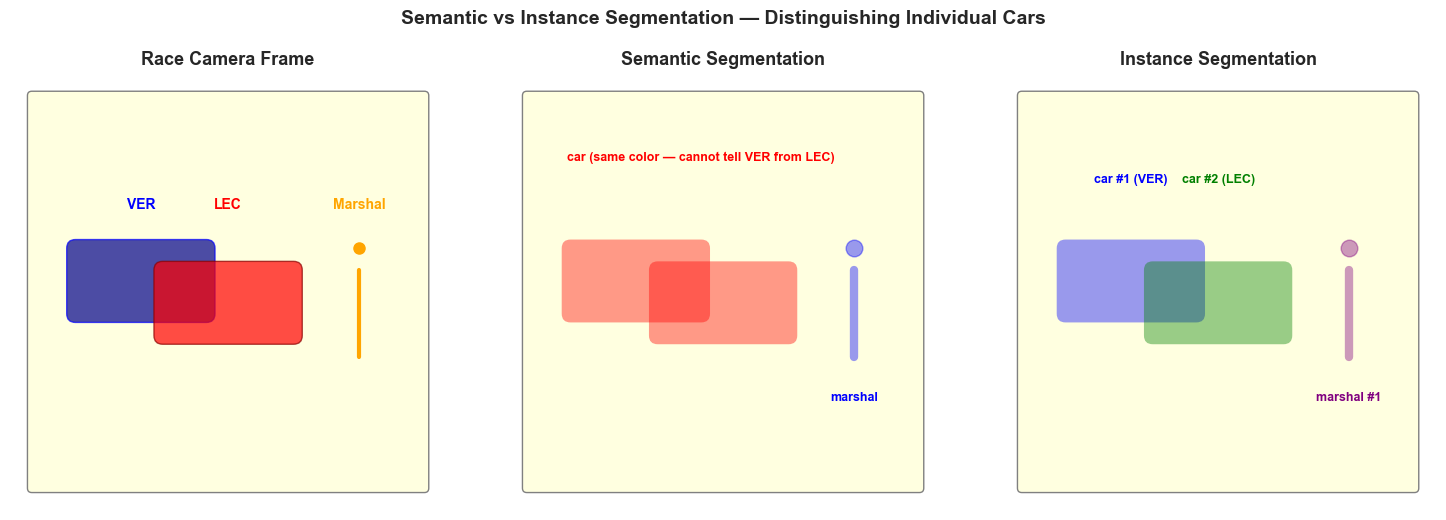

In [14]:
# Visualize the difference between semantic and instance segmentation on F1 cars
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax in axes:
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.set_aspect('equal')
    ax.axis('off')

# Original "race frame" — two cars and a marshal
ax = axes[0]
ax.set_title('Race Camera Frame', fontsize=13, fontweight='bold')
ax.add_patch(patches.FancyBboxPatch((0.5, 0.5), 9, 9, boxstyle="round,pad=0.1",
             facecolor='lightyellow', edgecolor='gray'))
# Car 1 (Red Bull)
car1 = patches.FancyBboxPatch((1.5, 4.5), 3, 1.5, boxstyle="round,pad=0.2",
                               facecolor='darkblue', edgecolor='blue', alpha=0.7)
ax.add_patch(car1)
# Car 2 (Ferrari) — slightly overlapping
car2 = patches.FancyBboxPatch((3.5, 4), 3, 1.5, boxstyle="round,pad=0.2",
                               facecolor='red', edgecolor='darkred', alpha=0.7)
ax.add_patch(car2)
# Marshal
ax.plot([8, 8], [3.5, 5.5], color='orange', linewidth=3)
ax.plot(8, 6, 'o', color='orange', markersize=8)
ax.text(3, 7, 'VER', ha='center', va='center', fontsize=10, fontweight='bold', color='blue')
ax.text(5, 7, 'LEC', ha='center', va='center', fontsize=10, fontweight='bold', color='red')
ax.text(8, 7, 'Marshal', ha='center', va='center', fontsize=10, fontweight='bold', color='orange')

# Semantic segmentation — both cars same color
ax = axes[1]
ax.set_title('Semantic Segmentation', fontsize=13, fontweight='bold')
ax.add_patch(patches.FancyBboxPatch((0.5, 0.5), 9, 9, boxstyle="round,pad=0.1",
             facecolor='lightyellow', edgecolor='gray'))
car1 = patches.FancyBboxPatch((1.5, 4.5), 3, 1.5, boxstyle="round,pad=0.2",
                               facecolor='red', edgecolor='none', alpha=0.4)
ax.add_patch(car1)
car2 = patches.FancyBboxPatch((3.5, 4), 3, 1.5, boxstyle="round,pad=0.2",
                               facecolor='red', edgecolor='none', alpha=0.4)
ax.add_patch(car2)
ax.plot([8, 8], [3.5, 5.5], color='blue', linewidth=6, alpha=0.4)
ax.plot(8, 6, 'o', color='blue', markersize=12, alpha=0.4)
ax.text(4.5, 8, 'car (same color — cannot tell VER from LEC)', fontsize=9, color='red', fontweight='bold', ha='center')
ax.text(8, 2.5, 'marshal', fontsize=9, color='blue', fontweight='bold', ha='center')

# Instance segmentation — each car gets a unique mask
ax = axes[2]
ax.set_title('Instance Segmentation', fontsize=13, fontweight='bold')
ax.add_patch(patches.FancyBboxPatch((0.5, 0.5), 9, 9, boxstyle="round,pad=0.1",
             facecolor='lightyellow', edgecolor='gray'))
car1 = patches.FancyBboxPatch((1.5, 4.5), 3, 1.5, boxstyle="round,pad=0.2",
                               facecolor='blue', edgecolor='none', alpha=0.4)
ax.add_patch(car1)
car2 = patches.FancyBboxPatch((3.5, 4), 3, 1.5, boxstyle="round,pad=0.2",
                               facecolor='green', edgecolor='none', alpha=0.4)
ax.add_patch(car2)
ax.plot([8, 8], [3.5, 5.5], color='purple', linewidth=6, alpha=0.4)
ax.plot(8, 6, 'o', color='purple', markersize=12, alpha=0.4)
ax.text(3, 7.5, 'car #1 (VER)', fontsize=9, color='blue', fontweight='bold', ha='center')
ax.text(5, 7.5, 'car #2 (LEC)', fontsize=9, color='green', fontweight='bold', ha='center')
ax.text(8, 2.5, 'marshal #1', fontsize=9, color='purple', fontweight='bold', ha='center')

plt.suptitle('Semantic vs Instance Segmentation — Distinguishing Individual Cars', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

---

## 6. Vision Transformers (ViT)

### Intuitive Explanation

Transformers revolutionized NLP (as we will see in notebooks 16-17). The natural question: can we use the same self-attention mechanism for images?

The challenge is scale: a 224x224 image has 50,176 pixels. Self-attention is O(n^2) in sequence length — applying it to every pixel would be prohibitively expensive.

**The ViT solution:** Divide the image into non-overlapping **patches** (e.g., 16x16 pixels), treat each patch as a "token" (like a word in NLP), and apply a standard Transformer encoder.

> **F1 Insight:** Think of it this way: instead of examining every individual pixel in a race camera frame, ViT divides the image into patches — each patch covers a section of track. One patch might contain the braking zone, another the apex, another the run-off area. Self-attention then lets every patch "look at" every other patch, so the model can understand relationships like "cars tend to be close together in this patch (hairpin) but spread out in that patch (long straight)."

#### The ViT Pipeline

1. **Split** the image into P x P patches (e.g., 16x16)
2. **Flatten** each patch into a vector (16 x 16 x 3 = 768 dimensions)
3. **Project** each flattened patch through a linear layer (the "patch embedding")
4. **Add positional embeddings** (so the model knows where each patch was on the track image)
5. **Prepend a [CLS] token** (for classification, like BERT)
6. **Feed through a standard Transformer encoder** (self-attention + FFN)
7. **Use the [CLS] token output** for classification

This is remarkably simple — and it works extremely well, especially with large datasets.

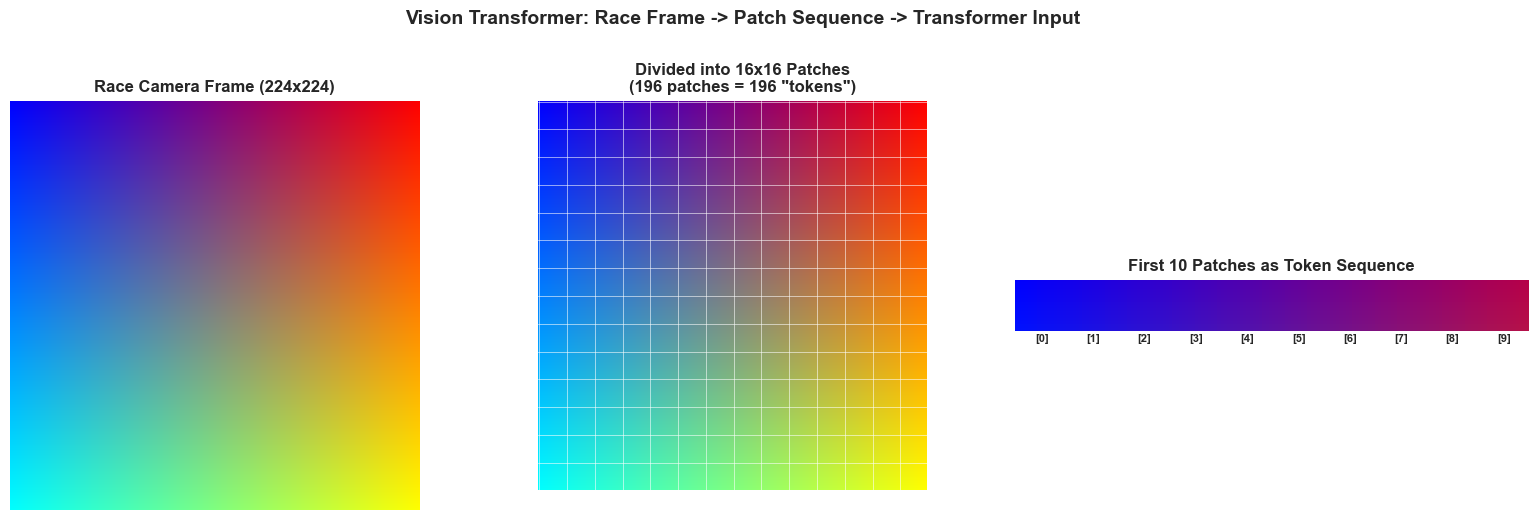

Race frame size: 224x224x3 = 150,528 values
Patch size: 16x16x3 = 768 values per patch
Number of patches: 196
Sequence length for Transformer: 196 + 1 (CLS token) = 197


In [15]:
# Visualize how a race camera frame gets split into patches for ViT
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

H, W = 224, 224
P = 16  # patch size
n_patches = (H // P) * (W // P)

# Generate a colorful image (simulated track view gradient)
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
xx, yy = np.meshgrid(x, y)
race_image = np.stack([xx, yy, 1 - xx], axis=-1)  # RGB gradient

# 1. Original race frame
ax = axes[0]
ax.imshow(race_image)
ax.set_title(f'Race Camera Frame ({H}x{W})', fontsize=12, fontweight='bold')
ax.axis('off')

# 2. Frame divided into patches
ax = axes[1]
ax.imshow(race_image)
for i in range(0, H + 1, P):
    ax.axhline(y=i, color='white', linewidth=0.5, alpha=0.8)
    ax.axvline(x=i, color='white', linewidth=0.5, alpha=0.8)
ax.set_title(f'Divided into {P}x{P} Patches\n({n_patches} patches = {n_patches} "tokens")', fontsize=12, fontweight='bold')
ax.axis('off')

# 3. Patches as a sequence (tokens for the Transformer)
ax = axes[2]
n_show = 10
patch_sequence = []
for i in range(0, min(n_show * P, H), P):
    patch = race_image[0:P, i:i+P]
    patch_sequence.append(patch)

combined = np.concatenate(patch_sequence, axis=1)
ax.imshow(combined)
ax.set_title(f'First {n_show} Patches as Token Sequence', fontsize=12, fontweight='bold')
ax.axis('off')

for i in range(n_show):
    ax.text(i * P + P/2, P + 3, f'[{i}]', ha='center', fontsize=8, fontweight='bold')

plt.suptitle('Vision Transformer: Race Frame -> Patch Sequence -> Transformer Input', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print(f"Race frame size: {H}x{W}x3 = {H*W*3:,} values")
print(f"Patch size: {P}x{P}x3 = {P*P*3} values per patch")
print(f"Number of patches: {n_patches}")
print(f"Sequence length for Transformer: {n_patches} + 1 (CLS token) = {n_patches + 1}")

In [16]:
class PatchEmbedding(nn.Module):
    """
    Convert a race camera frame into a sequence of patch embeddings.

    This is the core innovation of ViT: treat an image as a sequence of
    flattened patches, just like a sentence is a sequence of words.
    Each patch captures a section of the track/scene.

    Args:
        img_size: Input image size (assumes square)
        patch_size: Size of each patch (assumes square)
        in_channels: Number of input channels (3 for RGB)
        embed_dim: Dimension of the embedding space
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Linear projection of flattened patches
        # Equivalent to Conv2d with kernel_size=stride=patch_size
        self.projection = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        # Project patches: (B, C, H, W) -> (B, embed_dim, H/P, W/P)
        x = self.projection(x)
        # Flatten spatial dims: (B, embed_dim, H/P, W/P) -> (B, embed_dim, n_patches)
        x = x.flatten(2)
        # Transpose: (B, embed_dim, n_patches) -> (B, n_patches, embed_dim)
        x = x.transpose(1, 2)
        return x


class SimpleViT(nn.Module):
    """
    Simplified Vision Transformer for race frame classification.
    
    Could classify race images by: incident type, weather condition,
    track section, flag status, etc.

    Args:
        img_size: Input image size
        patch_size: Patch size
        in_channels: Input channels
        num_classes: Number of output classes
        embed_dim: Embedding dimension
        num_heads: Number of attention heads
        num_layers: Number of transformer layers
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=3,
                 num_classes=10, embed_dim=768, num_heads=8, num_layers=6):
        super().__init__()

        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches

        # Learnable [CLS] token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        # Positional embeddings (learnable — encodes where each patch is on the track)
        self.pos_embed = nn.Parameter(torch.randn(1, n_patches + 1, embed_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=embed_dim * 4, dropout=0.1,
            activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]

        # Patch embedding — split race frame into patch tokens
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)

        # Prepend CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, n_patches+1, embed_dim)

        # Add positional embeddings
        x = x + self.pos_embed

        # Transformer encoder — self-attention across all patches
        x = self.transformer(x)

        # Use CLS token for classification
        cls_output = self.norm(x[:, 0])
        return self.classifier(cls_output)

# Test the Vision Transformer on race frame classification
torch.manual_seed(42)
race_vit = SimpleViT(img_size=64, patch_size=8, in_channels=3,
                     num_classes=10, embed_dim=256, num_heads=8, num_layers=4)

race_frame_input = torch.randn(2, 3, 64, 64)
vit_output = race_vit(race_frame_input)

print(f"Input:  {race_frame_input.shape} -> (batch, channels, H, W)")
print(f"Output: {vit_output.shape} -> (batch, num_classes)")

n_patches = (64 // 8) ** 2
print(f"\nPatch size: 8x8 = 64 pixels per patch")
print(f"Number of patches: {n_patches}")
print(f"Sequence length: {n_patches + 1} (patches + CLS)")

total_params = sum(p.numel() for p in race_vit.parameters())
print(f"Total parameters: {total_params:,}")

Input:  torch.Size([2, 3, 64, 64]) -> (batch, channels, H, W)
Output: torch.Size([2, 10]) -> (batch, num_classes)

Patch size: 8x8 = 64 pixels per patch
Number of patches: 64
Sequence length: 65 (patches + CLS)
Total parameters: 3,228,426


### Deep Dive: CNN vs Vision Transformer

| Aspect | CNN | Vision Transformer (ViT) | F1 Analogy |
|--------|-----|-------------------------|------------|
| **Inductive bias** | Strong: locality, translation equivariance | Weak: only sequence order (via positional embeddings) | CNNs assume "nearby pixels matter most" (like analyzing a single corner); ViTs can look everywhere at once (like the race director scanning all cameras) |
| **Receptive field** | Grows gradually (layer by layer) | Global from layer 1 (self-attention sees all patches) | CNN: builds understanding corner-by-corner; ViT: sees the whole circuit immediately |
| **Data efficiency** | Better with small datasets (biases help) | Needs large datasets (or pretraining) to shine | CNN works with footage from a few races; ViT needs seasons of data |
| **Scalability** | Saturates with more data/compute | Scales well: more data leads to better performance | — |
| **Architecture** | Conv, Pool, Conv, Pool, FC | Patch Embed, Transformer Blocks, CLS head | — |
| **Position awareness** | Built-in (convolution is local) | Must be learned (positional embeddings) | — |
| **Compute** | O(kernel^2 x channels) per position | O(n_patches^2 x embed_dim) for self-attention | — |

#### Key Insight

CNNs build in **strong assumptions** about images (local patterns, translation invariance). These assumptions help with limited data but can also limit the model. ViTs make **fewer assumptions**, allowing them to learn more flexible representations — but they need more data to discover what CNNs get "for free." In practice, the best modern models often combine ideas from both: convolutional patch embeddings, local attention windows, etc.

#### Common Misconceptions

| Misconception | Reality |
|---------------|--------|
| "ViTs completely replaced CNNs" | Many state-of-the-art models are hybrids (e.g., ConvNeXt, Swin Transformer) |
| "ViTs need no spatial inductive bias" | Positional embeddings encode position; many variants add locality |
| "Bigger patches are always better" | Smaller patches capture more detail but increase sequence length quadratically |

---

## 7. CLIP: Connecting Vision and Language

### Intuitive Explanation

What if, instead of training a vision model on fixed class labels, we trained it to **understand the relationship between images and text**? That is the core idea behind CLIP (Contrastive Language-Image Pre-training) from OpenAI.

CLIP trains two separate encoders simultaneously:
- An **image encoder** (CNN or ViT) that maps images to a shared embedding space
- A **text encoder** (Transformer) that maps text descriptions to the same embedding space

The training objective is **contrastive**: in a batch of (image, text) pairs, maximize the similarity between matching pairs and minimize it for non-matching pairs.

> **F1 Insight:** Imagine searching through thousands of hours of race footage. Instead of manually tagging every frame, CLIP lets you type "Hamilton overtaking at Turn 1 in the rain" and find the matching frames. Or describe "safety car period with marshals on track" and retrieve exactly those moments. CLIP connects what you *see* in the footage to what you can *describe* in words.

#### Why CLIP Matters

1. **Zero-shot classification**: Classify race images into categories never seen during training, just by providing text descriptions
2. **Flexible**: No fixed label set — describe any scenario in natural language ("wet weather start," "tire puncture," "DRS zone overtake")
3. **Transfer learning**: CLIP features are remarkably general
4. **Multimodal foundation**: CLIP is a building block for text-to-image models (DALL-E, Stable Diffusion), visual question answering, and more

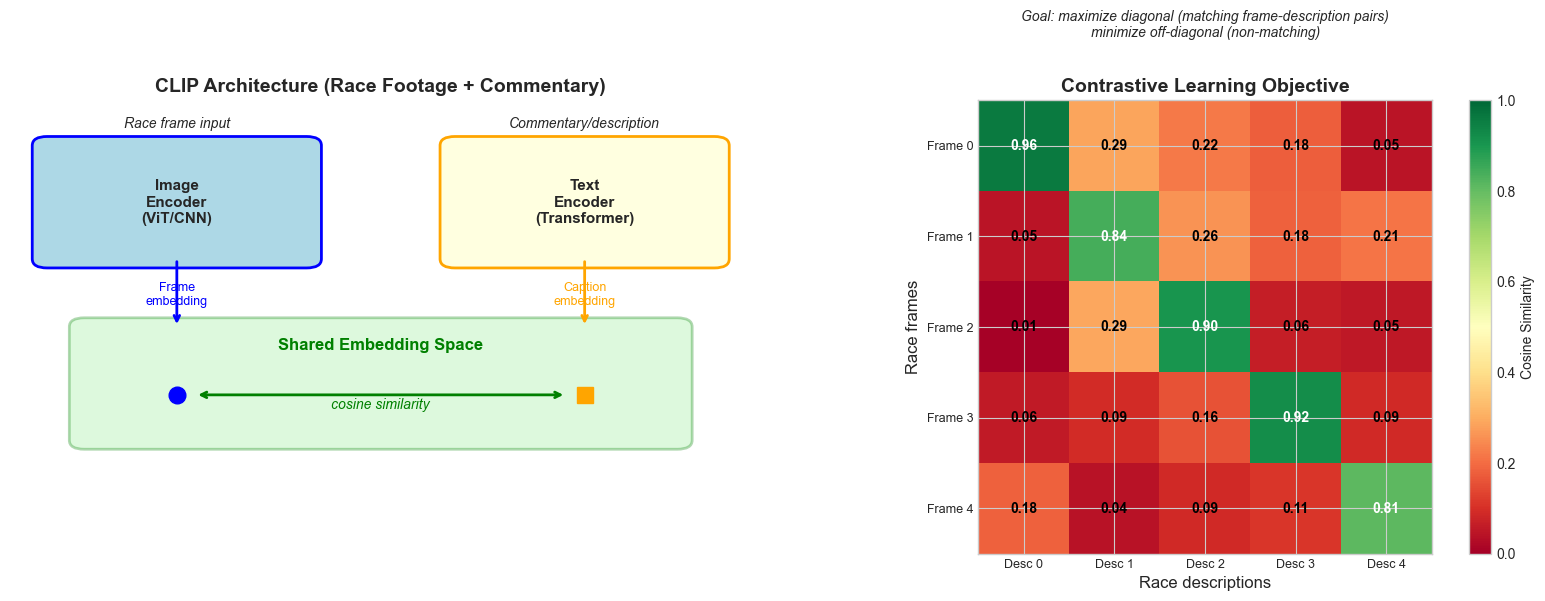

In [17]:
# Visualize CLIP's dual-encoder architecture and contrastive learning for race footage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Architecture
ax = axes[0]
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')
ax.set_title('CLIP Architecture (Race Footage + Commentary)', fontsize=14, fontweight='bold')

# Image encoder
img_box = patches.FancyBboxPatch((0.5, 6.5), 3.5, 2.5, boxstyle="round,pad=0.2",
                                  facecolor='lightblue', edgecolor='blue', linewidth=2)
ax.add_patch(img_box)
ax.text(2.25, 7.75, 'Image\nEncoder\n(ViT/CNN)', ha='center', va='center', fontsize=11, fontweight='bold')

# Text encoder
txt_box = patches.FancyBboxPatch((6, 6.5), 3.5, 2.5, boxstyle="round,pad=0.2",
                                  facecolor='lightyellow', edgecolor='orange', linewidth=2)
ax.add_patch(txt_box)
ax.text(7.75, 7.75, 'Text\nEncoder\n(Transformer)', ha='center', va='center', fontsize=11, fontweight='bold')

# Embeddings
ax.annotate('', xy=(2.25, 5.0), xytext=(2.25, 6.5),
            arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax.text(2.25, 5.5, 'Frame\nembedding', ha='center', fontsize=9, color='blue')

ax.annotate('', xy=(7.75, 5.0), xytext=(7.75, 6.5),
            arrowprops=dict(arrowstyle='->', color='orange', lw=2))
ax.text(7.75, 5.5, 'Caption\nembedding', ha='center', fontsize=9, color='orange')

# Shared embedding space
space_box = patches.FancyBboxPatch((1, 2.5), 8, 2.5, boxstyle="round,pad=0.2",
                                    facecolor='lightgreen', edgecolor='green', linewidth=2, alpha=0.3)
ax.add_patch(space_box)
ax.text(5, 4.5, 'Shared Embedding Space', ha='center', fontsize=12, fontweight='bold', color='green')

ax.plot(2.25, 3.5, 'bo', markersize=12)
ax.plot(7.75, 3.5, 's', color='orange', markersize=12)
ax.annotate('', xy=(7.5, 3.5), xytext=(2.5, 3.5),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2))
ax.text(5, 3.2, 'cosine similarity', ha='center', fontsize=10, color='green', style='italic')

ax.text(2.25, 9.4, 'Race frame input', ha='center', fontsize=10, style='italic')
ax.text(7.75, 9.4, 'Commentary/description', ha='center', fontsize=10, style='italic')

# Right: Contrastive learning matrix with F1 examples
ax = axes[1]
ax.set_title('Contrastive Learning Objective', fontsize=14, fontweight='bold')

batch_size = 5
np.random.seed(42)
sim_matrix = np.random.rand(batch_size, batch_size) * 0.3
for i in range(batch_size):
    sim_matrix[i, i] = 0.8 + np.random.rand() * 0.2

im = ax.imshow(sim_matrix, cmap='RdYlGn', vmin=0, vmax=1)
ax.set_xlabel('Race descriptions', fontsize=12)
ax.set_ylabel('Race frames', fontsize=12)
ax.set_xticks(range(batch_size))
ax.set_yticks(range(batch_size))
ax.set_xticklabels([f'Desc {i}' for i in range(batch_size)], fontsize=9)
ax.set_yticklabels([f'Frame {i}' for i in range(batch_size)], fontsize=9)

for i in range(batch_size):
    for j in range(batch_size):
        color = 'white' if sim_matrix[i, j] > 0.5 else 'black'
        ax.text(j, i, f'{sim_matrix[i, j]:.2f}', ha='center', va='center',
                fontsize=10, color=color, fontweight='bold')

plt.colorbar(im, ax=ax, label='Cosine Similarity')
ax.text(2, -1.2, 'Goal: maximize diagonal (matching frame-description pairs)\nminimize off-diagonal (non-matching)',
        ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

In [18]:
def clip_contrastive_loss(frame_embeddings, caption_embeddings, temperature=0.07):
    """
    Compute CLIP-style contrastive loss (InfoNCE / NT-Xent).
    
    In F1: aligns race frame embeddings with their matching commentary/descriptions.

    Args:
        frame_embeddings: (batch_size, embed_dim) -- L2 normalized race frame embeddings
        caption_embeddings: (batch_size, embed_dim) -- L2 normalized description embeddings
        temperature: scaling factor (lower = sharper distribution)

    Returns:
        Scalar loss value
    """
    # Normalize embeddings
    frame_embeddings = F.normalize(frame_embeddings, dim=-1)
    caption_embeddings = F.normalize(caption_embeddings, dim=-1)

    # Compute similarity matrix: (batch, batch)
    logits = frame_embeddings @ caption_embeddings.T / temperature

    # Labels: matching pairs are on the diagonal
    batch_size = logits.shape[0]
    labels = torch.arange(batch_size)

    # Cross-entropy loss in both directions
    loss_f2c = F.cross_entropy(logits, labels)       # frame -> caption
    loss_c2f = F.cross_entropy(logits.T, labels)     # caption -> frame

    return (loss_f2c + loss_c2f) / 2

# Demo: simulate CLIP training on race footage + commentary pairs
torch.manual_seed(42)
batch_size = 8
embed_dim = 128

# Simulated embeddings for race frames and their descriptions
race_frame_emb = torch.randn(batch_size, embed_dim)
race_caption_emb = torch.randn(batch_size, embed_dim)

# Make matching pairs slightly similar (simulate partially trained model)
race_caption_emb = race_caption_emb + 0.3 * race_frame_emb

loss = clip_contrastive_loss(race_frame_emb, race_caption_emb, temperature=0.07)
print(f"CLIP contrastive loss: {loss.item():.4f}")
print(f"Random baseline (batch={batch_size}): {np.log(batch_size):.4f}")
print(f"  (Loss should be lower than random baseline since frame-caption pairs are correlated)")

print("\nEffect of temperature:")
for temp in [0.01, 0.07, 0.1, 0.5, 1.0]:
    l = clip_contrastive_loss(race_frame_emb, race_caption_emb, temperature=temp)
    print(f"  temperature={temp:.2f} -> loss={l.item():.4f}")

CLIP contrastive loss: 0.3093
Random baseline (batch=8): 2.0794
  (Loss should be lower than random baseline since frame-caption pairs are correlated)

Effect of temperature:
  temperature=0.01 -> loss=0.0529
  temperature=0.07 -> loss=0.3093
  temperature=0.10 -> loss=0.5207
  temperature=0.50 -> loss=1.6135
  temperature=1.00 -> loss=1.8378


### Zero-Shot Classification with CLIP

One of CLIP's most powerful capabilities is classifying images into categories **it has never been explicitly trained on**. Here is how:

1. Given candidate class names: ["overtake", "pit stop", "safety car", "crash"]
2. Create text prompts: ["a photo of an overtake", "a photo of a pit stop", ...]
3. Encode all text prompts with the text encoder
4. Encode the input race frame with the image encoder
5. Compute cosine similarity between the frame embedding and each text embedding
6. The class with the highest similarity wins

No retraining needed — just change the text descriptions to classify into any set of categories.

> **F1 Insight:** This is transformative for race analysis. Instead of training separate models for "detect overtakes," "detect pit stops," "detect incidents," you train one CLIP model and then describe any scenario in words. Want to find "wet weather starts at Monaco"? Just type it. Want to detect "cars running wide at Copse corner"? Describe it. CLIP turns classification from a fixed-label problem into a **language-guided** problem.

**What this means:** Instead of retraining a model for every new task, you simply describe the task in words.

---

## 8. Transfer Learning for Vision

### Intuitive Explanation

Training a large vision model from scratch requires enormous datasets and compute. **Transfer learning** lets us reuse knowledge from a model pre-trained on a large dataset (like ImageNet with 1.2M images) and adapt it to our specific task.

> **F1 Insight:** Think of transfer learning like adapting across racing series. A model trained on millions of general images has already learned to detect edges, textures, and objects. Adapting it to F1 footage is like a driver moving from F2 to F1 — the core skills (vision features) transfer, but you need to fine-tune for the specific demands (higher speed, different cars, specific liveries). You could also transfer an F1-trained model to analyze F2 or IndyCar footage with minimal retraining.

There are two main approaches:

| Approach | What You Do | When to Use | F1 Example |
|----------|-------------|-------------|------------|
| **Feature extraction** | Freeze the pretrained backbone, only train a new classification head | Small dataset, similar domain to pretraining | You have 500 labeled F1 frames and want to classify incident types |
| **Fine-tuning** | Unfreeze some/all of the pretrained backbone, train end-to-end with a small learning rate | Medium-large dataset, different domain | You have 50,000 labeled F1 frames and want pixel-perfect car detection |

#### Practical Guidelines

1. **Start with feature extraction** — it is fast and often surprisingly effective
2. **If accuracy is insufficient, try fine-tuning** the last few layers first
3. **Use a small learning rate for fine-tuning** (10-100x smaller than for the new head)
4. **Apply data augmentation** — varying lighting (day/night races), weather (rain/dry), camera angles
5. **Freeze batch normalization** layers if fine-tuning with very small batches

In [19]:
# Transfer learning demo: adapt a pretrained ResNet to F1 race classification
import torchvision.models as models

# Load a pretrained ResNet-18 (trained on ImageNet — 1000 general categories)
resnet = models.resnet18(weights='IMAGENET1K_V1')

print("ResNet-18 final layers:")
print(f"  Average pool: {resnet.avgpool}")
print(f"  FC layer: {resnet.fc}")
print(f"  Original output: {resnet.fc.out_features} classes (ImageNet)")

# Approach 1: Feature extraction (freeze backbone, new head for F1 tasks)
# 10 F1 classes: overtake, pit_stop, safety_car, red_flag, start, crash, 
#                track_limits, tire_failure, drs_overtake, normal_racing
for param in resnet.parameters():
    param.requires_grad = False

num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)  # New head for 10 F1 event classes

# Count trainable vs frozen parameters
trainable = sum(p.numel() for p in resnet.parameters() if p.requires_grad)
total = sum(p.numel() for p in resnet.parameters())
frozen = total - trainable

print(f"\nAfter modification for 10 F1 event classes:")
print(f"  Total parameters:     {total:>10,}")
print(f"  Frozen parameters:    {frozen:>10,} ({100*frozen/total:.1f}%)")
print(f"  Trainable parameters: {trainable:>10,} ({100*trainable/total:.1f}%)")

# Test forward pass with a race frame
race_input = torch.randn(2, 3, 224, 224)
with torch.no_grad():
    race_output = resnet(race_input)
print(f"\nInput:  {race_input.shape}")
print(f"Output: {race_output.shape}")

ResNet-18 final layers:
  Average pool: AdaptiveAvgPool2d(output_size=(1, 1))
  FC layer: Linear(in_features=512, out_features=1000, bias=True)
  Original output: 1000 classes (ImageNet)

After modification for 10 F1 event classes:
  Total parameters:     11,181,642
  Frozen parameters:    11,176,512 (100.0%)
  Trainable parameters:      5,130 (0.0%)

Input:  torch.Size([2, 3, 224, 224])
Output: torch.Size([2, 10])


In [20]:
# Approach 2: Fine-tuning (unfreeze last layers for deeper F1 adaptation)
resnet_ft = models.resnet18(weights='IMAGENET1K_V1')

# First freeze everything
for param in resnet_ft.parameters():
    param.requires_grad = False

# Unfreeze the last residual block (layer4) — lets the model learn F1-specific features
for param in resnet_ft.layer4.parameters():
    param.requires_grad = True

# Replace the classification head for F1 events
num_features = resnet_ft.fc.in_features
resnet_ft.fc = nn.Linear(num_features, 10)

# Count trainable parameters
trainable_ft = sum(p.numel() for p in resnet_ft.parameters() if p.requires_grad)
total_ft = sum(p.numel() for p in resnet_ft.parameters())

print("Fine-tuning approach (unfreeze layer4 + new head for F1):")
print(f"  Total parameters:     {total_ft:>10,}")
print(f"  Trainable parameters: {trainable_ft:>10,} ({100*trainable_ft/total_ft:.1f}%)")

print("\nTypical optimizer setup for fine-tuning on F1 data:")
print("  optimizer = torch.optim.Adam([")
print("      {'params': model.layer4.parameters(), 'lr': 1e-4},  # Pretrained: small LR")
print("      {'params': model.fc.parameters(), 'lr': 1e-3},      # New F1 head: larger LR")
print("  ])")

print("\n" + "="*60)
print(f"{'Approach':<25} {'Trainable Params':>20} {'% of Total':>12}")
print("="*60)
print(f"{'Feature extraction':<25} {trainable:>20,} {100*trainable/total:>11.1f}%")
print(f"{'Fine-tune layer4':<25} {trainable_ft:>20,} {100*trainable_ft/total_ft:>11.1f}%")
print(f"{'Full fine-tuning':<25} {total_ft:>20,} {'100.0':>11}%")
print("="*60)

Fine-tuning approach (unfreeze layer4 + new head for F1):
  Total parameters:     11,181,642
  Trainable parameters:  8,398,858 (75.1%)

Typical optimizer setup for fine-tuning on F1 data:
  optimizer = torch.optim.Adam([
      {'params': model.layer4.parameters(), 'lr': 1e-4},  # Pretrained: small LR
      {'params': model.fc.parameters(), 'lr': 1e-3},      # New F1 head: larger LR
  ])

Approach                      Trainable Params   % of Total
Feature extraction                       5,130         0.0%
Fine-tune layer4                     8,398,858        75.1%
Full fine-tuning                    11,181,642       100.0%


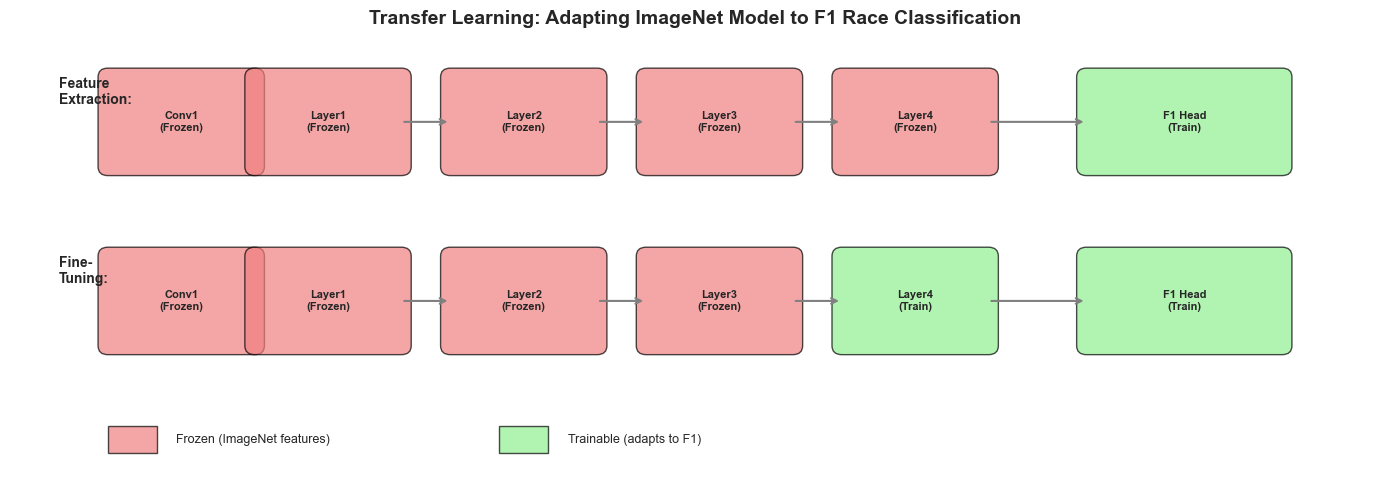

In [21]:
# Visualize what gets frozen vs fine-tuned when adapting to F1
fig, ax = plt.subplots(figsize=(14, 5))
ax.set_xlim(0, 14)
ax.set_ylim(0, 5)
ax.axis('off')

layers = [
    ('Conv1', 1.0, 'lightblue'),
    ('Layer1', 2.5, 'lightblue'),
    ('Layer2', 4.5, 'lightblue'),
    ('Layer3', 6.5, 'lightblue'),
    ('Layer4', 8.5, 'lightyellow'),
    ('F1 Head', 11.0, 'lightgreen'),
]

ax.text(0.5, 4.5, 'Feature\nExtraction:', fontsize=10, fontweight='bold', va='top')
ax.text(0.5, 2.5, 'Fine-\nTuning:', fontsize=10, fontweight='bold', va='top')

for name, x_pos, color in layers:
    w = 1.5 if name != 'F1 Head' else 2.0

    # Feature extraction row (top)
    c = 'lightgreen' if name == 'F1 Head' else 'lightcoral'
    label = 'Train' if name == 'F1 Head' else 'Frozen'
    rect = patches.FancyBboxPatch((x_pos, 3.5), w, 1.0, boxstyle="round,pad=0.1",
                                   facecolor=c, edgecolor='black', alpha=0.7)
    ax.add_patch(rect)
    ax.text(x_pos + w/2, 4.0, f'{name}\n({label})', ha='center', va='center', fontsize=8, fontweight='bold')

    # Fine-tuning row (bottom)
    if name in ['Layer4', 'F1 Head']:
        c = 'lightgreen'
        label = 'Train'
    else:
        c = 'lightcoral'
        label = 'Frozen'
    rect = patches.FancyBboxPatch((x_pos, 1.5), w, 1.0, boxstyle="round,pad=0.1",
                                   facecolor=c, edgecolor='black', alpha=0.7)
    ax.add_patch(rect)
    ax.text(x_pos + w/2, 2.0, f'{name}\n({label})', ha='center', va='center', fontsize=8, fontweight='bold')

# Arrows
for i in range(len(layers)-1):
    x_from = layers[i][1] + (1.5 if layers[i][0] != 'F1 Head' else 2.0)
    x_to = layers[i+1][1]
    for y in [4.0, 2.0]:
        ax.annotate('', xy=(x_to, y), xytext=(x_from, y),
                    arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

# Legend
ax.add_patch(patches.Rectangle((1, 0.3), 0.5, 0.3, facecolor='lightcoral', edgecolor='black', alpha=0.7))
ax.text(1.7, 0.45, 'Frozen (ImageNet features)', fontsize=9, va='center')
ax.add_patch(patches.Rectangle((5.0, 0.3), 0.5, 0.3, facecolor='lightgreen', edgecolor='black', alpha=0.7))
ax.text(5.7, 0.45, 'Trainable (adapts to F1)', fontsize=9, va='center')

ax.set_title('Transfer Learning: Adapting ImageNet Model to F1 Race Classification', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## Exercises

### Exercise 1: Batch IoU for Multi-Car Detection Evaluation

During an F1 race, your detection model predicts bounding boxes for every car in a camera frame, and you have ground truth annotations for where each car actually is. To evaluate detection quality, you need to compute IoU between **every predicted box** and **every ground truth box** efficiently.

Implement a function that computes IoU between every pair of boxes in two sets — a common operation in detection evaluation (like computing mAP). Your function should use vectorized NumPy operations (no loops) for efficiency.

In [22]:
# EXERCISE 1: Batch IoU for evaluating car detection accuracy
def batch_iou(predicted_cars, ground_truth_cars):
    """
    Compute pairwise IoU between predicted car boxes and ground truth car boxes.

    Args:
        predicted_cars: numpy array of shape (N, 4), each row is [x1, y1, x2, y2]
        ground_truth_cars: numpy array of shape (M, 4), each row is [x1, y1, x2, y2]

    Returns:
        IoU matrix of shape (N, M) where iou[i, j] = IoU(predicted[i], truth[j])

    Hint: Use broadcasting! Expand predicted_cars to (N, 1, 4) and ground_truth_cars to (1, M, 4)
    """
    # TODO: Implement this!
    # Step 1: Compute intersection coordinates using np.maximum and np.minimum
    # Step 2: Compute intersection areas (clamp to 0 for non-overlapping)
    # Step 3: Compute areas of each box
    # Step 4: Compute union = area_predicted + area_truth - intersection
    # Step 5: Return intersection / union

    pass

# Test: predicted car positions vs ground truth positions
predicted_cars = np.array([
    [0, 0, 3, 3],   # Predicted position for car A
    [1, 1, 4, 4],   # Predicted position for car B
])
ground_truth_cars = np.array([
    [0, 0, 3, 3],   # Actual position of car 1 (perfect match with prediction A)
    [2, 2, 5, 5],   # Actual position of car 2
    [6, 6, 9, 9],   # Actual position of car 3 (no overlap with any prediction)
])

result = batch_iou(predicted_cars, ground_truth_cars)

expected = np.array([
    [1.0, compute_iou([0,0,3,3], [2,2,5,5]), 0.0],
    [compute_iou([1,1,4,4], [0,0,3,3]), compute_iou([1,1,4,4], [2,2,5,5]), 0.0],
])

if result is not None:
    print(f"Your IoU matrix (predicted vs ground truth):\n{result}")
    print(f"\nExpected:\n{expected}")
    print(f"\nCorrect: {np.allclose(result, expected)}")
else:
    print("Expected IoU matrix (predicted vs ground truth):")
    print(expected)
    print("\nImplement batch_iou to verify!")

Expected IoU matrix (predicted vs ground truth):
[[1.         0.05882353 0.        ]
 [0.28571429 0.28571429 0.        ]]

Implement batch_iou to verify!


### Exercise 2: Implement Patch Embedding from Scratch (No Conv2d)

The `PatchEmbedding` class above uses `nn.Conv2d` as a shortcut. Implement it from scratch using only reshaping and a linear layer — this makes the process more explicit and reinforces understanding.

Think of it as manually cutting a race camera frame into a grid of patches (each showing a section of the track) and then projecting each patch into an embedding vector.

In [23]:
# EXERCISE 2: Patch embedding without Conv2d — manual race frame patching
class ManualPatchEmbedding(nn.Module):
    """
    Implement patch embedding using explicit reshape + linear projection.
    No Conv2d allowed!

    Like manually cutting a race camera frame into grid patches (each showing
    a section of track, grandstand, or run-off) and projecting each into
    an embedding vector.

    Steps:
    1. Reshape frame from (B, C, H, W) to (B, n_patches, patch_size*patch_size*C)
    2. Apply a linear layer to project each flattened patch to embed_dim

    Hint: Use tensor.reshape() and careful dimension ordering.
    """
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        patch_dim = patch_size * patch_size * in_channels

        # TODO: Create a linear layer that maps patch_dim -> embed_dim
        self.projection = None  # Replace with nn.Linear(...)

    def forward(self, x):
        """
        Args:
            x: (batch, channels, height, width) — a race camera frame
        Returns:
            (batch, n_patches, embed_dim) — patch embeddings for the Transformer
        """
        B, C, H, W = x.shape
        P = self.patch_size

        # TODO: Reshape x into patches
        # Step 1: Reshape to (B, C, H//P, P, W//P, P)
        # Step 2: Permute to (B, H//P, W//P, C, P, P)
        # Step 3: Reshape to (B, n_patches, C*P*P)
        # Step 4: Apply self.projection

        pass

# Test
torch.manual_seed(42)
# Uncomment after implementing:
# manual_pe = ManualPatchEmbedding(img_size=64, patch_size=8, in_channels=3, embed_dim=256)
# race_frame = torch.randn(2, 3, 64, 64)
# patch_tokens = manual_pe(race_frame)
# print(f"Input race frame: {race_frame.shape}")
# print(f"Output patch tokens: {patch_tokens.shape}")
# print(f"Expected: torch.Size([2, 64, 256])")
# print(f"Correct shape: {patch_tokens.shape == torch.Size([2, 64, 256])}")

print("Uncomment the test code above after implementing ManualPatchEmbedding!")
print("Expected output shape: (2, 64, 256)")
print("  2 = batch size (two race frames)")
print("  64 = (64/8)^2 = 64 patches per frame")
print("  256 = embed_dim")

Uncomment the test code above after implementing ManualPatchEmbedding!
Expected output shape: (2, 64, 256)
  2 = batch size (two race frames)
  64 = (64/8)^2 = 64 patches per frame
  256 = embed_dim


### Exercise 3: Add Dice Loss for Track Segmentation

Cross-entropy is the standard loss for classification, but for segmentation it can be problematic when classes are imbalanced. In F1 track segmentation, the **track surface** might dominate 70% of pixels while **curbing** covers only 2% — cross-entropy would learn to ignore the rare curbing class.

**Dice loss** directly optimizes the Dice coefficient, which measures overlap between prediction and ground truth, and is much more robust to class imbalance:

$$\text{Dice} = \frac{2 |A \cap B|}{|A| + |B|}$$

Implement Dice loss for binary segmentation (e.g., "is this pixel part of the track surface or not?").

In [24]:
# EXERCISE 3: Dice loss for track boundary segmentation
def dice_loss(pred, target, smooth=1e-6):
    """
    Compute Dice loss for binary track segmentation.
    
    Example: predicting which pixels are track surface vs everything else.

    Args:
        pred: (batch, 1, H, W) -- raw logits (apply sigmoid first!)
        target: (batch, 1, H, W) -- binary ground truth (0=not track, 1=track)
        smooth: smoothing factor to avoid division by zero

    Returns:
        1 - Dice coefficient (so that minimizing loss = maximizing Dice)

    Steps:
        1. Apply sigmoid to pred to get probabilities
        2. Flatten both pred and target to (batch, H*W)
        3. Compute intersection: sum(pred * target) per sample
        4. Compute Dice = (2 * intersection + smooth) / (sum(pred) + sum(target) + smooth)
        5. Return 1 - mean(Dice)
    """
    # TODO: Implement this!

    pass

# Test with track segmentation examples
torch.manual_seed(42)

# Ground truth: a 4x4 square of track surface in an 8x8 frame
track_mask = torch.zeros(1, 1, 8, 8)
track_mask[0, 0, 2:6, 2:6] = 1.0  # track surface pixels

# Near-perfect prediction (model correctly identifies track region)
pred_good = torch.zeros(1, 1, 8, 8) - 5.0  # low logits everywhere (not track)
pred_good[0, 0, 2:6, 2:6] = 5.0  # high logits where track actually is

# Bad prediction (random — model has not learned track boundaries)
pred_bad = torch.randn(1, 1, 8, 8)

if dice_loss(pred_good, track_mask) is not None:
    loss_good = dice_loss(pred_good, track_mask)
    loss_bad = dice_loss(pred_bad, track_mask)
    print(f"Dice loss (accurate track prediction): {loss_good.item():.4f} (should be close to 0)")
    print(f"Dice loss (random prediction):         {loss_bad.item():.4f} (should be higher)")
    print(f"\nAccurate < Random: {loss_good.item() < loss_bad.item()}")
else:
    print("Implement dice_loss to verify!")
    print("Expected: accurate track prediction loss close to 0.0, random prediction loss > 0.3")

Implement dice_loss to verify!
Expected: accurate track prediction loss close to 0.0, random prediction loss > 0.3


---

## Summary

### Key Concepts

| Concept | What It Does | F1 Parallel |
|---------|-------------|-------------|
| **Object Detection** | Decomposes into anchor boxes, IoU scoring, class prediction, and NMS post-processing | Detecting cars, marshals, flags, and debris in race camera frames |
| **IoU (Intersection over Union)** | The standard metric for measuring bounding box overlap — values from 0 (no overlap) to 1 (perfect) | How well your predicted car position matches the actual car position |
| **Non-Maximum Suppression (NMS)** | Removes duplicate detections by suppressing lower-confidence overlapping boxes | Picking the single best bounding box when 5 boxes all claim to detect the same car |
| **YOLO** | Frames detection as a single-pass regression problem — predicts boxes and classes from a grid simultaneously | Real-time race monitoring at 30+ fps during live broadcasts |
| **Semantic Segmentation** | Assigns a class to every pixel using encoder-decoder architectures like U-Net | Mapping every pixel as track, curbing, gravel, grass, or barrier |
| **U-Net** | Uses skip connections to combine deep semantic features with fine spatial details | Combining "this area is a corner" knowledge with "the exact track boundary is here" precision |
| **Transposed Convolutions** | Learnable upsampling operations that recover spatial resolution | Recovering pixel-level track boundaries from compressed feature maps |
| **Instance Segmentation** | Combines detection with per-instance mask prediction (Mask R-CNN) | Giving each of 20 cars its own unique pixel mask |
| **Vision Transformers (ViT)** | Treat images as sequences of patches and apply Transformer self-attention | Dividing a race frame into patches and letting each patch attend to all others |
| **CLIP** | Connects vision and language through contrastive learning in a shared embedding space | Searching race footage by typing "Hamilton overtaking in the rain at Turn 1" |
| **Transfer Learning** | Reuses pretrained features — freeze backbone or fine-tune with small learning rate | Adapting an ImageNet model to F1 footage; adapting F1 model to F2/IndyCar |

### Connection to Deep Learning

| Concept | Where It Appears | Why It Matters |
|---------|-----------------|----------------|
| IoU and NMS | Every detection model | Standard evaluation and post-processing |
| Anchor boxes | YOLO, SSD, Faster R-CNN | Efficient candidate generation |
| Encoder-decoder | U-Net, segmentation, autoencoders | Compress then reconstruct spatial information |
| Skip connections | U-Net, ResNet, DenseNet | Preserve information across depth |
| Patch embeddings | ViT, DINO, MAE | Bridge images and Transformers |
| Contrastive learning | CLIP, SimCLR, DINO | Learn representations without explicit labels |
| Transfer learning | Nearly every practical vision system | Train with limited data by reusing pretrained features |

### Checklist

- [ ] I can compute IoU between two bounding boxes by hand
- [ ] I understand how anchor boxes tile an image with candidate regions at different scales
- [ ] I can explain NMS and why it is needed to avoid duplicate car detections
- [ ] I understand YOLO's grid-based, single-pass detection approach and why it enables real-time race monitoring
- [ ] I can describe the U-Net encoder-decoder architecture and the role of skip connections in recovering track boundaries
- [ ] I know the difference between semantic, instance, and panoptic segmentation
- [ ] I can explain how ViT converts a race frame into a sequence of patch tokens
- [ ] I understand CLIP's contrastive learning objective and how it enables searching footage by description
- [ ] I know when to use feature extraction vs fine-tuning for transfer learning

---

## Next Steps

In **Notebook 15: Recurrent Neural Networks (RNNs)**, we shift from spatial data (images) to **sequential data** (text, time series, audio). We will explore how RNNs maintain a hidden state that carries information forward through a sequence, why vanilla RNNs struggle with long-range dependencies, and how LSTM and GRU architectures solve the vanishing gradient problem.

The ideas from this notebook — particularly attention mechanisms (ViT) and encoder-decoder architectures (U-Net) — will reappear in new forms as we move into sequence modeling and eventually the full Transformer architecture. And in F1 terms, we are moving from analyzing what you *see* (camera frames) to analyzing what unfolds *over time* (lap-by-lap telemetry, stint strategies, race narratives).